# AIS WBM
---
### Script for the WBM side of GBM
+ The saved, optimised trained model will be used to predict SOG 
+ Predicted SOG then converted to STW
+ STW then will be used to predict FOC
+ Power estimation using [HoltropMennen84](https://repository.tudelft.nl/islandora/object/uuid%3Aca12a502-fc85-45e4-a078-db7284127e3c)
---
### General Remarks 
+ Please remember to save the model used in BBM part
+ This file should be saved on local directory
+ Running time is significantly shorter 
---
### Package initialisation
+ Loading of standard packages

In [88]:
import pandas as pd
import numpy as np
import math
import joblib
import matplotlib.pyplot as plt
# Gridpsec used for plotting
import matplotlib.gridspec as gridspec

### Loading of models 

In [89]:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif"
# })

# model_rfr_ftr = joblib.load('savemodel_rfr_ftr.sav')
# model_rfr_hpov = joblib.load('savemodel_rfr_ftr_hpov.sav')

# model_etr = joblib.load('savemodel_etr.sav')
# model_etr_hpov = joblib.load('savemodel_etr_hpov.sav')

# model_dtr_ftr = joblib.load('savemodel_dtr_ftr.sav')
# model_dtr_hpov = joblib.load('savemodel_dtr_hpov.sav')

# model_mlr_ftr = joblib.load('savemodel_mlr_ftr.sav')

In [90]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

model_rfr_ftr = joblib.load('savemodel_rfr_ftr_all.sav')
model_rfr_hpov = joblib.load('savemodel_rfr_ftr_hpov_all.sav')

model_etr = joblib.load('savemodel_etr_all.sav')
model_etr_hpov = joblib.load('savemodel_etr_hpov_all.sav')

model_dtr_ftr = joblib.load('savemodel_dtr_ftr_all.sav')
model_dtr_hpov = joblib.load('savemodel_dtr_hpov_all.sav')

model_mlr_ftr = joblib.load('savemodel_mlr_ftr_all.sav')

### Loading dataset

In [91]:
# Parameter to plot in latex fonts
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

# Load the data to the script

# dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
# dfmain = dfmain[dfmain['LAT'] > 55.04 ]
dfmain = pd.read_csv("07.AIS_Weather_Hammershus_Adjustment.csv",parse_dates=["Time"])



dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
# dfpre = dfpre[dfpre['LAT'] > 55.04 ]

In [92]:
# dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
# dfmain = dfmain[dfmain['LAT'] > 55.04 ]

# dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
# dfpre = dfpre[dfpre['LAT'] > 55.04 ]

### Same as main script, preprocessing of current and wind 

In [93]:
# Drop the wind speed and current speed from the original dataset as it contains outlier 

dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [94]:
# Drop all dulplicate feature in dataset "AIS_weather_h_rename_copy.csv"

dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog
count,7996.000000,7996.000000,6484.000000,6484.000000,7996.000000,7996.000000
mean,2.003343,0.392822,0.016498,0.002614,9.494577,235.187508
std,5.375081,4.429148,0.099565,0.081342,8.642616,110.907338
min,-15.766171,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241
25%,-1.817300,-2.534309,-0.036435,-0.044409,0.000000,121.743958
50%,2.328315,0.379647,0.018883,0.003008,13.208600,280.852407
75%,5.956965,3.375402,0.072324,0.046731,18.136035,343.500000
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115


Imputing value in the preprocessed dataset

In [95]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [96]:
x_pre = imputer.transform(dfpre)

In [97]:
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [98]:
# Calculate current and wind speed

dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [99]:
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog,Current Speed,Wind Speed
count,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000
mean,2.003343,0.392822,0.019283,0.003526,9.494577,235.187508,0.097503,6.572812
std,5.375081,4.429148,0.090691,0.074213,8.642616,110.907338,0.067887,3.077302
min,-15.766171,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241,0.000735,0.193221
25%,-1.817300,-2.534309,-0.022360,-0.034024,0.000000,121.743958,0.047933,4.184091
50%,2.328315,0.379647,0.025365,0.003481,13.208600,280.852407,0.079960,6.338558
75%,5.956965,3.375402,0.062914,0.039807,18.136035,343.500000,0.129117,8.619488
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115,0.525174,17.933977


In [100]:
# Calculate the True North wind direction and split them into quadrants

condwind = [(dfpre['eastwind']>0) & (dfpre['northwind']<0),
            (dfpre['eastwind']<0) & (dfpre['northwind']>0),
            (dfpre['eastwind']>0) & (dfpre['northwind']>0)]

choicewind = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"])))]

dfpre["True North Wind Direction"] = np.select(condwind, choicewind, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))))


In [101]:
# Calculate the True North current direction and split them into quadrants

condcurr = [(dfpre['eastcurrent']<0) & (dfpre['northcurrent']>0),
            (dfpre['eastcurrent']>0) & (dfpre['northcurrent']<0),
            (dfpre['eastcurrent']<0) & (dfpre['northcurrent']<0)]

choicecurr = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"])))]

dfpre["True North Current Direction"] = np.select(condcurr, choicecurr, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))))

In [102]:
# Descriptive statistics of the dataset for true north weather direction

dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [103]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

,Unnamed: 0,Time,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,...,Draught,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
0,0,2021-01-01 00:00:00,14.689663,55.098452,277.311035,1.259323,1.893614,4.818881,3.818459,4.154329,...,5.0,155.408180,105.591754,22.854050,22.749664,22.610062,0.122270,7.112664,251.408180,68.408246
1,1,2021-01-01 01:00:00,14.689658,55.098451,277.328369,1.259985,1.752303,4.755800,3.470216,4.130580,...,5.0,158.458891,99.679168,26.122772,19.152008,22.209274,0.122270,6.653538,254.458891,68.408246
2,2,2021-01-01 02:00:00,14.689649,55.098468,277.390625,1.260244,1.619775,4.645083,3.259682,4.083755,...,5.0,163.749663,99.679168,28.498383,12.424911,20.857971,0.099846,6.488697,259.749663,57.259552
3,3,2021-01-01 03:00:00,14.689646,55.098471,277.411377,1.260148,1.518736,4.588384,3.177906,4.010502,...,5.0,170.724504,116.740448,29.956985,6.725922,18.732071,0.099846,6.104632,266.724504,57.259552
4,4,2021-01-01 04:00:00,14.689644,55.098462,277.430664,1.260634,1.455034,4.528841,3.281654,3.913362,...,5.0,179.505940,99.679168,34.486298,3.761627,15.731430,0.099846,6.181707,174.494060,57.259552


### SOG threshold
+ The threshold for the ships manouvering speed will be 5 knots ([Abebe20](https://doi.org/10.3390/app10072325),[Yan21](https://doi.org/10.1016/j.tre.2020.101930))
+ Alternatively, outlier rejection using &mu; &plusmn; 3&sigma; ([Gkerekos19](https://doi.org/10.1016/j.oceaneng.2019.106282)), this should increase the threshold to about 8 knots

In [104]:
# SOG threshold according to Abebe20 and Yan21

df = df[df['SOG'] > 0 ]


# df = df[df['SOG'] > 5 ]

# # Improve model performance ? , reduce skew of the dataset by removing outliers mu pm 3sigma 

# df = df[df['SOG'] > 8 ]

### Data split into testing dataset
+ The `random_state` is 42, however to gain different datasets, change the `random_state` to other numbers (arbitrary), but make sure the same ``random_state`` is applied to the main BBM script that is used for the split
+ The testing dataset is further split into
    + Summer dataset ``dfsummer``
    + Winter dataset ``dfwinter``
    + Year dataset ``dfyear``, which represents the ``test_set``

In [105]:
# Exclude data for the month of June to check the model's forecasting performance 

from sklearn.model_selection import train_test_split

#When performing the split, make sure that the random state is the same as the training script

train_set, test_set = train_test_split(df, test_size=0.25, random_state=42)

print("Summer Dataset Breakdown")
dfMay = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-05']
print(f"length of May dataset {len(dfMay)}")
dfJune = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-06']
print(f"length of June dataset {len(dfJune)}")
dfJuly = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-07']
print(f"length of July dataset {len(dfJuly)}")
dfAug = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-08']
print(f"length of August dataset {len(dfAug)}")
dfSep = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-09']
print(f"length of Sept dataset {len(dfSep)}")
dfOct = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-10']
print(f"length of Oct dataset {len(dfOct)}")

print("Winter Dataset Breakdown")
dfNov = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-11']
print(f"length of Nov dataset {len(dfNov)}")
dfDec = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-12']
print(f"length of Dec dataset {len(dfDec)}")
dfJan = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-01']
print(f"length of Jan dataset {len(dfJan)}")
dfFeb = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-02']
print(f"length of Feb dataset {len(dfFeb)}")
dfMar = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-03']
print(f"length of March dataset {len(dfMar)}")
dfApr = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-04']
print(f"length of April dataset {len(dfApr)}")


frames_summer = [dfMay,dfJune,dfJuly,dfAug,dfSep,dfOct]
frames_winter = [dfNov,dfDec,dfJan,dfFeb,dfMar,dfApr]

dfsummer = pd.concat(frames_summer)
dfwinter = pd.concat(frames_winter)
dfyear = test_set

Summer Dataset Breakdown
length of May dataset 96
length of June dataset 114
length of July dataset 146
length of August dataset 135
length of Sept dataset 116
length of Oct dataset 138
Winter Dataset Breakdown
length of Nov dataset 109
length of Dec dataset 120
length of Jan dataset 125
length of Feb dataset 116
length of March dataset 107
length of April dataset 108


Descriptive statistics of different datasets

In [106]:
print(dfsummer.describe())

        Unnamed: 0         LON         LAT  Temperature above oceans  \
count   745.000000  745.000000  745.000000                745.000000   
mean   5195.546309   13.618208   55.173168                288.197733   
std    1236.416507    0.873287    0.304058                  3.737520   
min    2882.000000   10.653272   54.477248                278.347168   
25%    4203.000000   12.866404   55.097825                285.557861   
50%    5228.000000   13.929031   55.183631                288.854492   
75%    6270.000000   14.486536   55.273822                290.984131   
max    7286.000000   14.691415   57.464056                297.026611   

       Air density above oceans  Max wave height  Swell period  \
count                735.000000       652.000000    652.000000   
mean                   1.217869         1.382263      3.969324   
std                    0.019626         1.119620      1.057867   
min                    1.170450         0.107192      1.967748   
25%                  

In [107]:
print(dfwinter.describe())

        Unnamed: 0         LON         LAT  Temperature above oceans  \
count   685.000000  685.000000  685.000000                685.000000   
mean   3600.931387   13.506536   55.215499                277.061812   
std    3211.281324    0.876790    0.206112                  3.281621   
min      17.000000   10.544123   54.475554                266.114777   
25%     987.000000   12.587750   55.123524                275.052979   
50%    2104.000000   13.591523   55.215252                277.048340   
75%    7631.000000   14.451782   55.333362                279.242920   
max    8736.000000   14.690215   57.437176                286.223145   

       Air density above oceans  Max wave height  Swell period  \
count                665.000000       575.000000    575.000000   
mean                   1.269906         1.802122      4.522565   
std                    0.022150         1.202764      1.053373   
min                    1.206596         0.176935      2.036522   
25%                  

In [108]:
print(dfyear.describe())

        Unnamed: 0          LON          LAT  Temperature above oceans  \
count  1430.000000  1430.000000  1430.000000               1430.000000   
mean   4431.692308    13.564715    55.193446                282.863393   
std    2523.292975     0.876439     0.262519                  6.587627   
min      17.000000    10.544123    54.475554                266.114777   
25%    2260.000000    12.694702    55.098454                277.200134   
50%    4658.500000    13.688262    55.200606                282.897949   
75%    6683.500000    14.472037    55.322688                288.996826   
max    8736.000000    14.691415    57.464056                297.026611   

       Air density above oceans  Max wave height  Swell period  \
count               1400.000000      1227.000000   1227.000000   
mean                   1.242587         1.579019      4.228585   
std                    0.033327         1.177651      1.090874   
min                    1.170450         0.107192      1.967748   
25%

### Data Preprocessing
+ Similar to BBM
+ Ensure that the dataset have identical data structure for the trained model 

In [109]:
# For Summer
dfsummer= dfsummer.drop(['Unnamed: 0','Time','LON','LAT','Width','Length'],axis=1)
# For Winter
dfwinter= dfwinter.drop(['Unnamed: 0','Time','LON','LAT','Width','Length'],axis=1)
# For the whole year of 2021
dfyear= dfyear.drop(['Unnamed: 0','Time','LON','LAT','Width','Length'],axis=1)


In [110]:
# # For Summer
# dfsummer= dfsummer.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
# 'Surface pressure','Width','Length'],axis=1)
# # For Winter
# dfwinter= dfwinter.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
# 'Surface pressure','Width','Length'],axis=1)
# # For the whole year of 2021
# dfyear= dfyear.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
# 'Surface pressure','Width','Length'],axis=1)


In [111]:
#For Summer
dfsummer= dfsummer.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir',
                            'Air density above oceans' : 'rho_air_ao',
                            'Surface pressure' : 'p_seasurf',
                           }, axis=1) 
#For Winter
dfwinter= dfwinter.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir','Air density above oceans' : 'rho_air_ao',
                            'Surface pressure' : 'p_seasurf',
                           }, axis=1) 
#For the whole year
dfyear= dfyear.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir','Air density above oceans' : 'rho_air_ao',
                            'Surface pressure' : 'p_seasurf',
                           }, axis=1) 

In [112]:
# # Rearrange column to match model 
# # Also dropping the features as described in the main script

# # For summer 

# df_summer = dfsummer[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir']]
# # For Winter

# df_winter = dfwinter[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir']]
# # For the whole year

# df_year = dfyear[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir']]

In [113]:
# Rearrange column to match model 
# Also dropping the features as described in the main script

# For summer 

df_summer = dfsummer[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir','rho_air_ao','p_seasurf']]
# For Winter

df_winter = dfwinter[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir','rho_air_ao','p_seasurf']]
# For the whole year

df_year = dfyear[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir','rho_air_ao','p_seasurf']]

Imputing to complete the data

In [114]:
import numpy as np
from sklearn.impute import KNNImputer

imputer_s = KNNImputer(n_neighbors=50)
imputer_s.fit(df_summer)

# Transform imputed summer dataset

xsummer = imputer_s.transform(df_summer)

# Column heading set same

df_summer_tr = pd.DataFrame(xsummer, columns=df_summer.columns, index=df_summer.index)

In [115]:
# Impute for winter data 

imputer_w = KNNImputer(n_neighbors=50)
imputer_w.fit(df_winter)

# Transform imputed winter dataset

xwinter = imputer_w.transform(df_winter)

#Column heading set same 

df_winter_tr = pd.DataFrame(xwinter, columns=df_winter.columns, index=df_winter.index)


In [116]:
# Impute for yearly data 

imputer_yr = KNNImputer(n_neighbors=50)
imputer_yr.fit(df_year)

# Transform imputed year dataset 

xyear = imputer_yr.transform(df_year)

#Column heading set same

df_year_tr = pd.DataFrame(xyear, columns=df_year.columns, index=df_year.index)

In [117]:
df_year_tr.describe()

,oceantemperature,waveheight,swellperiod,windwaveperiod,waveperiod,surftemp,windwaveswellheight,swellheight,windwaveheight,draught,...,curspeed,truewinddir,truecurrentdir,trueswelldir,truewindwavedir,truewavedir,truenorthwinddir,truenorthcurrentdir,rho_air_ao,p_seasurf
count,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1.430000e+03,1430.000000,...,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000
mean,282.863393,1.585584,4.232849,3.408819,3.797357,283.779423,0.831898,0.383140,6.699215e-01,5.176948,...,0.099502,90.139348,88.182907,87.185785,90.159349,87.508365,193.771919,154.402393,1.242634,101338.205726
std,6.587627,1.104158,1.020194,0.943869,0.896033,5.884230,0.565310,0.188647,5.916107e-01,0.219256,...,0.066671,54.650059,54.560287,49.979947,48.944616,50.696249,88.869579,97.506604,0.033032,986.644412
min,266.114777,0.107192,1.967748,1.570717,1.967748,273.048584,0.070604,0.070659,2.507146e-16,4.700000,...,0.001416,0.040806,0.369323,0.224765,0.029311,0.125756,0.121903,0.281785,1.170450,97178.312500
25%,277.200134,0.763643,3.502174,2.728874,3.161146,278.317383,0.410441,0.256724,2.164307e-01,5.000000,...,0.050190,40.730764,31.494377,45.130794,53.244616,45.495409,140.385159,78.603379,1.215066,100724.015625
50%,282.897949,1.341774,4.179894,3.364497,3.715221,283.468018,0.708183,0.350363,5.396818e-01,5.200000,...,0.086354,91.371460,88.352599,86.622068,91.067318,86.427724,198.232365,141.047705,1.241388,101469.562500
75%,288.996826,2.075973,4.881524,3.864906,4.351968,289.384521,1.087195,0.464980,9.279484e-01,5.313617,...,0.127402,140.135383,147.452326,126.986407,126.615526,129.528550,268.391280,218.553816,1.268963,101991.750000
max,297.026611,7.311599,7.517778,7.092444,7.085897,295.046387,3.780643,2.209327,3.732544e+00,5.700000,...,0.413716,179.861808,179.779332,179.917834,179.922589,179.882823,359.236303,359.532314,1.348105,103961.562500


In [118]:
# Summer dataset
x_date_s = df_summer_tr.drop(['sog'],axis=1)
y_date_s = df_summer_tr.sog
# winter dataset
x_date_w = df_winter_tr.drop(['sog'],axis=1)
y_date_w = df_winter_tr.sog
# Year dataset
x_date_yr = df_year_tr.drop(['sog'],axis=1)
y_date_yr = df_year_tr.sog

In [119]:
print(f"Amount of the test dataset is {len(x_date_yr)}")
print(f"Amount of the summer dataset is {len(x_date_s)}")
print(f"Amount of the winter dataset is {len(x_date_w)}")

Amount of the test dataset is 1430
Amount of the summer dataset is 745
Amount of the winter dataset is 685


Histogram plots of the yearly dataset

In [121]:
# # plt.rcParams.update(plt.rcParamsDefault) # Alter default value 
# axes = df_year_tr.hist(bins=50,figsize=(10,50),color='black',grid=True,layout=(11,2))
# for ax in axes.flatten():
#     ax.grid(True, linestyle='--', alpha=0.5)
# plt.show()

In [122]:
x_date_yr.describe()

,oceantemperature,waveheight,swellperiod,windwaveperiod,waveperiod,surftemp,windwaveswellheight,swellheight,windwaveheight,draught,...,curspeed,truewinddir,truecurrentdir,trueswelldir,truewindwavedir,truewavedir,truenorthwinddir,truenorthcurrentdir,rho_air_ao,p_seasurf
count,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1.430000e+03,1430.000000,...,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000
mean,282.863393,1.585584,4.232849,3.408819,3.797357,283.779423,0.831898,0.383140,6.699215e-01,5.176948,...,0.099502,90.139348,88.182907,87.185785,90.159349,87.508365,193.771919,154.402393,1.242634,101338.205726
std,6.587627,1.104158,1.020194,0.943869,0.896033,5.884230,0.565310,0.188647,5.916107e-01,0.219256,...,0.066671,54.650059,54.560287,49.979947,48.944616,50.696249,88.869579,97.506604,0.033032,986.644412
min,266.114777,0.107192,1.967748,1.570717,1.967748,273.048584,0.070604,0.070659,2.507146e-16,4.700000,...,0.001416,0.040806,0.369323,0.224765,0.029311,0.125756,0.121903,0.281785,1.170450,97178.312500
25%,277.200134,0.763643,3.502174,2.728874,3.161146,278.317383,0.410441,0.256724,2.164307e-01,5.000000,...,0.050190,40.730764,31.494377,45.130794,53.244616,45.495409,140.385159,78.603379,1.215066,100724.015625
50%,282.897949,1.341774,4.179894,3.364497,3.715221,283.468018,0.708183,0.350363,5.396818e-01,5.200000,...,0.086354,91.371460,88.352599,86.622068,91.067318,86.427724,198.232365,141.047705,1.241388,101469.562500
75%,288.996826,2.075973,4.881524,3.864906,4.351968,289.384521,1.087195,0.464980,9.279484e-01,5.313617,...,0.127402,140.135383,147.452326,126.986407,126.615526,129.528550,268.391280,218.553816,1.268963,101991.750000
max,297.026611,7.311599,7.517778,7.092444,7.085897,295.046387,3.780643,2.209327,3.732544e+00,5.700000,...,0.413716,179.861808,179.779332,179.917834,179.922589,179.882823,359.236303,359.532314,1.348105,103961.562500


In [123]:
# Ignore this part for latex export

# stats_DSyear = x_date_yr.describe().transpose()
# print(stats_DSyear.to_latex(index=False,

#                   formatters={"name": str.upper},

#                   float_format="{:.2f}".format,

# ))  

In [124]:
y_date_yr.describe()

count    1430.000000
mean       14.270611
std         6.407961
min         0.000273
25%        12.225047
50%        17.344856
75%        18.590115
max        21.070492
Name: sog, dtype: float64

In [125]:
x_date_s.describe()

,oceantemperature,waveheight,swellperiod,windwaveperiod,waveperiod,surftemp,windwaveswellheight,swellheight,windwaveheight,draught,...,curspeed,truewinddir,truecurrentdir,trueswelldir,truewindwavedir,truewavedir,truenorthwinddir,truenorthcurrentdir,rho_air_ao,p_seasurf
count,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,7.450000e+02,745.000000,...,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000
mean,288.197733,1.390462,3.976440,3.309675,3.593307,288.579985,0.731450,0.344540,5.788171e-01,5.193264,...,0.094193,90.843813,89.648464,87.555610,89.961499,87.558450,193.966404,154.177945,1.217824,101355.875839
std,3.737520,1.059116,0.995456,0.910226,0.865965,3.650382,0.539489,0.159412,5.714660e-01,0.224210,...,0.066920,55.904952,53.983789,51.991576,49.138940,53.428960,85.671055,103.312733,0.019527,820.709333
min,278.347168,0.107192,1.967748,1.570717,1.967748,278.303833,0.070604,0.070659,2.507146e-16,4.700000,...,0.001416,0.148370,0.369323,0.404303,0.029311,0.125756,2.695914,0.281785,1.170450,97801.812500
25%,285.557861,0.614089,3.238856,2.610878,2.930254,286.375704,0.334487,0.228644,1.396484e-01,5.000000,...,0.045638,40.227244,32.276483,42.466446,52.626815,41.201065,137.784279,77.183839,1.202929,100862.062500
50%,288.854492,1.120069,3.923565,3.240900,3.495082,289.280640,0.596299,0.317474,4.406281e-01,5.200000,...,0.078264,90.636080,93.202509,87.657630,89.534822,85.447898,195.253913,124.537310,1.215619,101432.437500
75%,290.984131,1.824555,4.622211,3.864882,4.108571,291.372437,0.956096,0.425568,8.087105e-01,5.400000,...,0.127089,143.669452,146.795580,130.238532,127.848753,132.260355,271.464496,244.680402,1.232815,101870.875000
max,297.026611,5.793899,6.992472,6.188758,6.191917,295.046387,2.950672,1.152069,2.884644e+00,5.700000,...,0.413716,179.764747,178.725680,179.554676,179.922589,179.882823,358.771465,359.450078,1.266453,103640.750000


In [126]:
# # Ignore this part for latex export

# stats_DSsummer = x_date_s.describe().transpose()
# print(stats_DSsummer.to_latex(index=False,

#                   formatters={"name": str.upper},

#                   float_format="{:.2f}".format,

# ))  

In [127]:
y_date_s.describe()

count    745.000000
mean      14.288412
std        6.339460
min        0.000273
25%       12.154439
50%       17.215356
75%       18.634934
max       21.070492
Name: sog, dtype: float64

In [128]:
x_date_w.describe()

,oceantemperature,waveheight,swellperiod,windwaveperiod,waveperiod,surftemp,windwaveswellheight,swellheight,windwaveheight,draught,...,curspeed,truewinddir,truecurrentdir,trueswelldir,truewindwavedir,truewavedir,truenorthwinddir,truenorthcurrentdir,rho_air_ao,p_seasurf
count,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,6.850000e+02,685.000000,...,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000
mean,277.061812,1.798823,4.516535,3.515747,4.023006,278.487116,0.941657,0.425647,7.693292e-01,5.159203,...,0.106197,89.373177,86.588980,86.933446,90.193155,87.547221,192.181395,154.643071,1.269975,101318.987865
std,3.281621,1.113793,0.975649,0.967864,0.876633,2.419024,0.572970,0.208538,5.978353e-01,0.212482,...,0.066000,53.281916,55.175699,47.570538,48.506601,47.298881,92.777365,91.031734,0.021881,1140.346944
min,266.114777,0.176935,2.036522,1.603139,2.011009,273.048584,0.111497,0.109539,2.536182e-16,4.700000,...,0.004258,0.040806,0.507972,0.224765,0.092660,0.324488,0.121903,0.587267,1.206596,97178.312500
25%,275.052979,0.995592,3.913634,2.833595,3.455495,276.691162,0.531084,0.291962,3.247070e-01,5.000000,...,0.058314,41.658551,30.674612,48.064612,53.770540,51.483917,139.764179,82.113261,1.255830,100526.812500
50%,277.048340,1.581527,4.451812,3.435428,3.948828,278.137695,0.832892,0.389038,6.728522e-01,5.200000,...,0.095493,91.506950,80.861400,86.233750,91.684420,88.289682,198.481062,155.264861,1.270367,101534.125000
75%,279.242920,2.329129,5.069295,4.022782,4.478737,279.446045,1.215751,0.506405,1.064692e+00,5.300000,...,0.129256,136.260372,148.363525,124.199379,125.439813,125.943518,262.486795,204.541457,1.281857,102150.062500
max,286.223145,7.311599,7.517778,7.092444,7.085897,284.604492,3.780643,2.209327,3.732544e+00,5.700000,...,0.364561,179.861808,179.779332,179.917834,179.759722,179.802032,359.236303,359.532314,1.348105,103961.562500


In [129]:
# # Ignore this part for latex export

# stats_DSwinter = x_date_w.describe().transpose()
# print(stats_DSwinter.to_latex(index=False,

#                   formatters={"name": str.upper},

#                   float_format="{:.2f}".format,

# ))  

In [130]:
y_date_w.describe()

count    685.000000
mean      14.251250
std        6.486222
min        0.000275
25%       12.402381
50%       17.480699
75%       18.564720
max       20.935750
Name: sog, dtype: float64

### Evaluating model performance on the testing datasets
+ Same metrics used for cross validation, but now MAPE is added

In [131]:
def evaluate_SOG(model,x_date,y_date):
    from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_error
    
    def label_predict(model,test_features):
        predictions = model.predict(test_features)
        return predictions
    
    predictions = label_predict(model,x_date)

    Rsquared_SOG = r2_score(y_date,predictions)
    expVar_SOG = explained_variance_score(y_date,predictions)
    MAE_SOG = mean_absolute_error(y_date,predictions)
    RMSE_SOG = np.sqrt(mean_squared_error(y_date, predictions))
    MAD_SOG = median_absolute_error(y_date,predictions)
    MAPE_SOG = mean_absolute_percentage_error(y_date, predictions)
    

    print(f"Model Performance of {model}")
    print(f"R^2 SOG = {Rsquared_SOG:0.4f}")
    print(f"Explained Variance SOG = {expVar_SOG:0.4f}")
    print(f"MAE SOG = {MAE_SOG:0.4f} Knots")    
    print(f"RMSE SOG = {RMSE_SOG:0.4f} Knots")
    print(f"MAD SOG = {MAD_SOG:0.4f} Knots")    
    print(f"MAPE SOG = {MAPE_SOG*100:0.4f} %")

ETR

In [132]:
# Year dataset
evaluate_SOG(model_etr_hpov,x_date_yr,y_date_yr)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 SOG = 0.9515
Explained Variance SOG = 0.9515
MAE SOG = 0.8238 Knots
RMSE SOG = 1.4108 Knots
MAD SOG = 0.5109 Knots
MAPE SOG = 2809.3627 %


In [133]:
evaluate_SOG(model_etr_hpov,x_date_w,y_date_w)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 SOG = 0.9396
Explained Variance SOG = 0.9396
MAE SOG = 0.8654 Knots
RMSE SOG = 1.5927 Knots
MAD SOG = 0.5238 Knots
MAPE SOG = 2008.1143 %


In [134]:
evaluate_SOG(model_etr_hpov,x_date_s,y_date_s)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 SOG = 0.9627
Explained Variance SOG = 0.9627
MAE SOG = 0.7869 Knots
RMSE SOG = 1.2233 Knots
MAD SOG = 0.5135 Knots
MAPE SOG = 3599.3381 %


RFR

In [135]:
evaluate_SOG(model_rfr_hpov,x_date_yr,y_date_yr)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 SOG = 0.9542
Explained Variance SOG = 0.9542
MAE SOG = 0.7418 Knots
RMSE SOG = 1.3711 Knots
MAD SOG = 0.4393 Knots
MAPE SOG = 1655.6598 %


In [136]:
evaluate_SOG(model_rfr_hpov,x_date_w,y_date_w)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 SOG = 0.9458
Explained Variance SOG = 0.9459
MAE SOG = 0.7905 Knots
RMSE SOG = 1.5083 Knots
MAD SOG = 0.4507 Knots
MAPE SOG = 1571.3811 %


In [137]:
evaluate_SOG(model_rfr_hpov,x_date_s,y_date_s)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 SOG = 0.9623
Explained Variance SOG = 0.9623
MAE SOG = 0.6993 Knots
RMSE SOG = 1.2303 Knots
MAD SOG = 0.4388 Knots
MAPE SOG = 1728.3484 %


DTR


In [138]:
evaluate_SOG(model_dtr_hpov,x_date_yr,y_date_yr)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 SOG = 0.9290
Explained Variance SOG = 0.9291
MAE SOG = 0.9533 Knots
RMSE SOG = 1.7075 Knots
MAD SOG = 0.5011 Knots
MAPE SOG = 1119.1375 %


In [139]:
evaluate_SOG(model_dtr_hpov,x_date_w,y_date_w)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 SOG = 0.9279
Explained Variance SOG = 0.9280
MAE SOG = 0.9327 Knots
RMSE SOG = 1.7408 Knots
MAD SOG = 0.4902 Knots
MAPE SOG = 274.4105 %


In [140]:
evaluate_SOG(model_dtr_hpov,x_date_s,y_date_s)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 SOG = 0.9317
Explained Variance SOG = 0.9318
MAE SOG = 0.9691 Knots
RMSE SOG = 1.6557 Knots
MAD SOG = 0.5212 Knots
MAPE SOG = 1895.7059 %


MLR

In [141]:
evaluate_SOG(model_mlr_ftr,x_date_yr,y_date_yr)

Model Performance of LinearRegression()
R^2 SOG = 0.4689
Explained Variance SOG = 0.4696
MAE SOG = 2.3894 Knots
RMSE SOG = 4.6684 Knots
MAD SOG = 1.7763 Knots
MAPE SOG = 31899.6354 %


In [142]:
evaluate_SOG(model_mlr_ftr,x_date_s,y_date_s)

Model Performance of LinearRegression()
R^2 SOG = 0.4858
Explained Variance SOG = 0.4868
MAE SOG = 2.3393 Knots
RMSE SOG = 4.5428 Knots
MAD SOG = 1.7394 Knots
MAPE SOG = 32851.2181 %


In [143]:
evaluate_SOG(model_mlr_ftr,x_date_w,y_date_w)

Model Performance of LinearRegression()
R^2 SOG = 0.4510
Explained Variance SOG = 0.4516
MAE SOG = 2.4417 Knots
RMSE SOG = 4.8024 Knots
MAD SOG = 1.7899 Knots
MAPE SOG = 30828.6165 %


### Plot of predicted vs actual SOG values

In [211]:
# fit a y = mx + c for the predicted vs actual  

from numpy import arange
from scipy.optimize import curve_fit

# plt.figure(figsize=(5,5))

# define the true objective function
def objective(x, a, b ):
	return a * x + b

def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

def pred_plot(model,modelname,test_feature,test_label):
    
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    from sklearn.linear_model import LinearRegression
    predict = label_predict(model,test_feature)

    from sklearn.metrics import r2_score

    print(r2_score(test_label, predict))

    # choose the input and output variables
    x, y = test_label, predict

    reg = LinearRegression().fit(x.values.reshape(-1,1) , y)
    b = reg.intercept_
    m = reg.coef_[0]
    plt.axline(xy1=(0, b), slope=m, label=rf'$y = {m:.3f}x {b:+.3f}$',color = 'r', ls ='--')

    # curve fit
    popt, _ = curve_fit(objective, x, y)

    # summarize the parameter values
    a, b = popt
    print('y = %.1f * x + %.1f' % (a, b ))

    # plot input vs output
    
    plt.scatter(x, y,edgecolors='black')
    
    # define a sequence of inputs between the smallest and largest known inputs
    
    x_line = arange(min(x), max(x), 1)
        
    # calculate the output for the range
    
    y_line = objective(x_line, a, b)
    
    # create a line plot for the mapping function
    
    # plt.plot(x_line, y_line, color='red')
    plt.xlabel(r'Predicted SOG [$kts$]', fontsize=13)
    plt.ylabel(r'Actual SOG [$kts$]', fontsize=13)
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.title(rf"{modelname}", fontsize=14)
    plt.xlim(0,25)
    plt.ylim(0,25)
    plt.legend(fontsize=14)



0.9289504265576506
y = 0.9 * x + 1.0
0.9541851539649099
y = 0.9 * x + 1.0
0.9514931190957533
y = 0.9 * x + 1.3


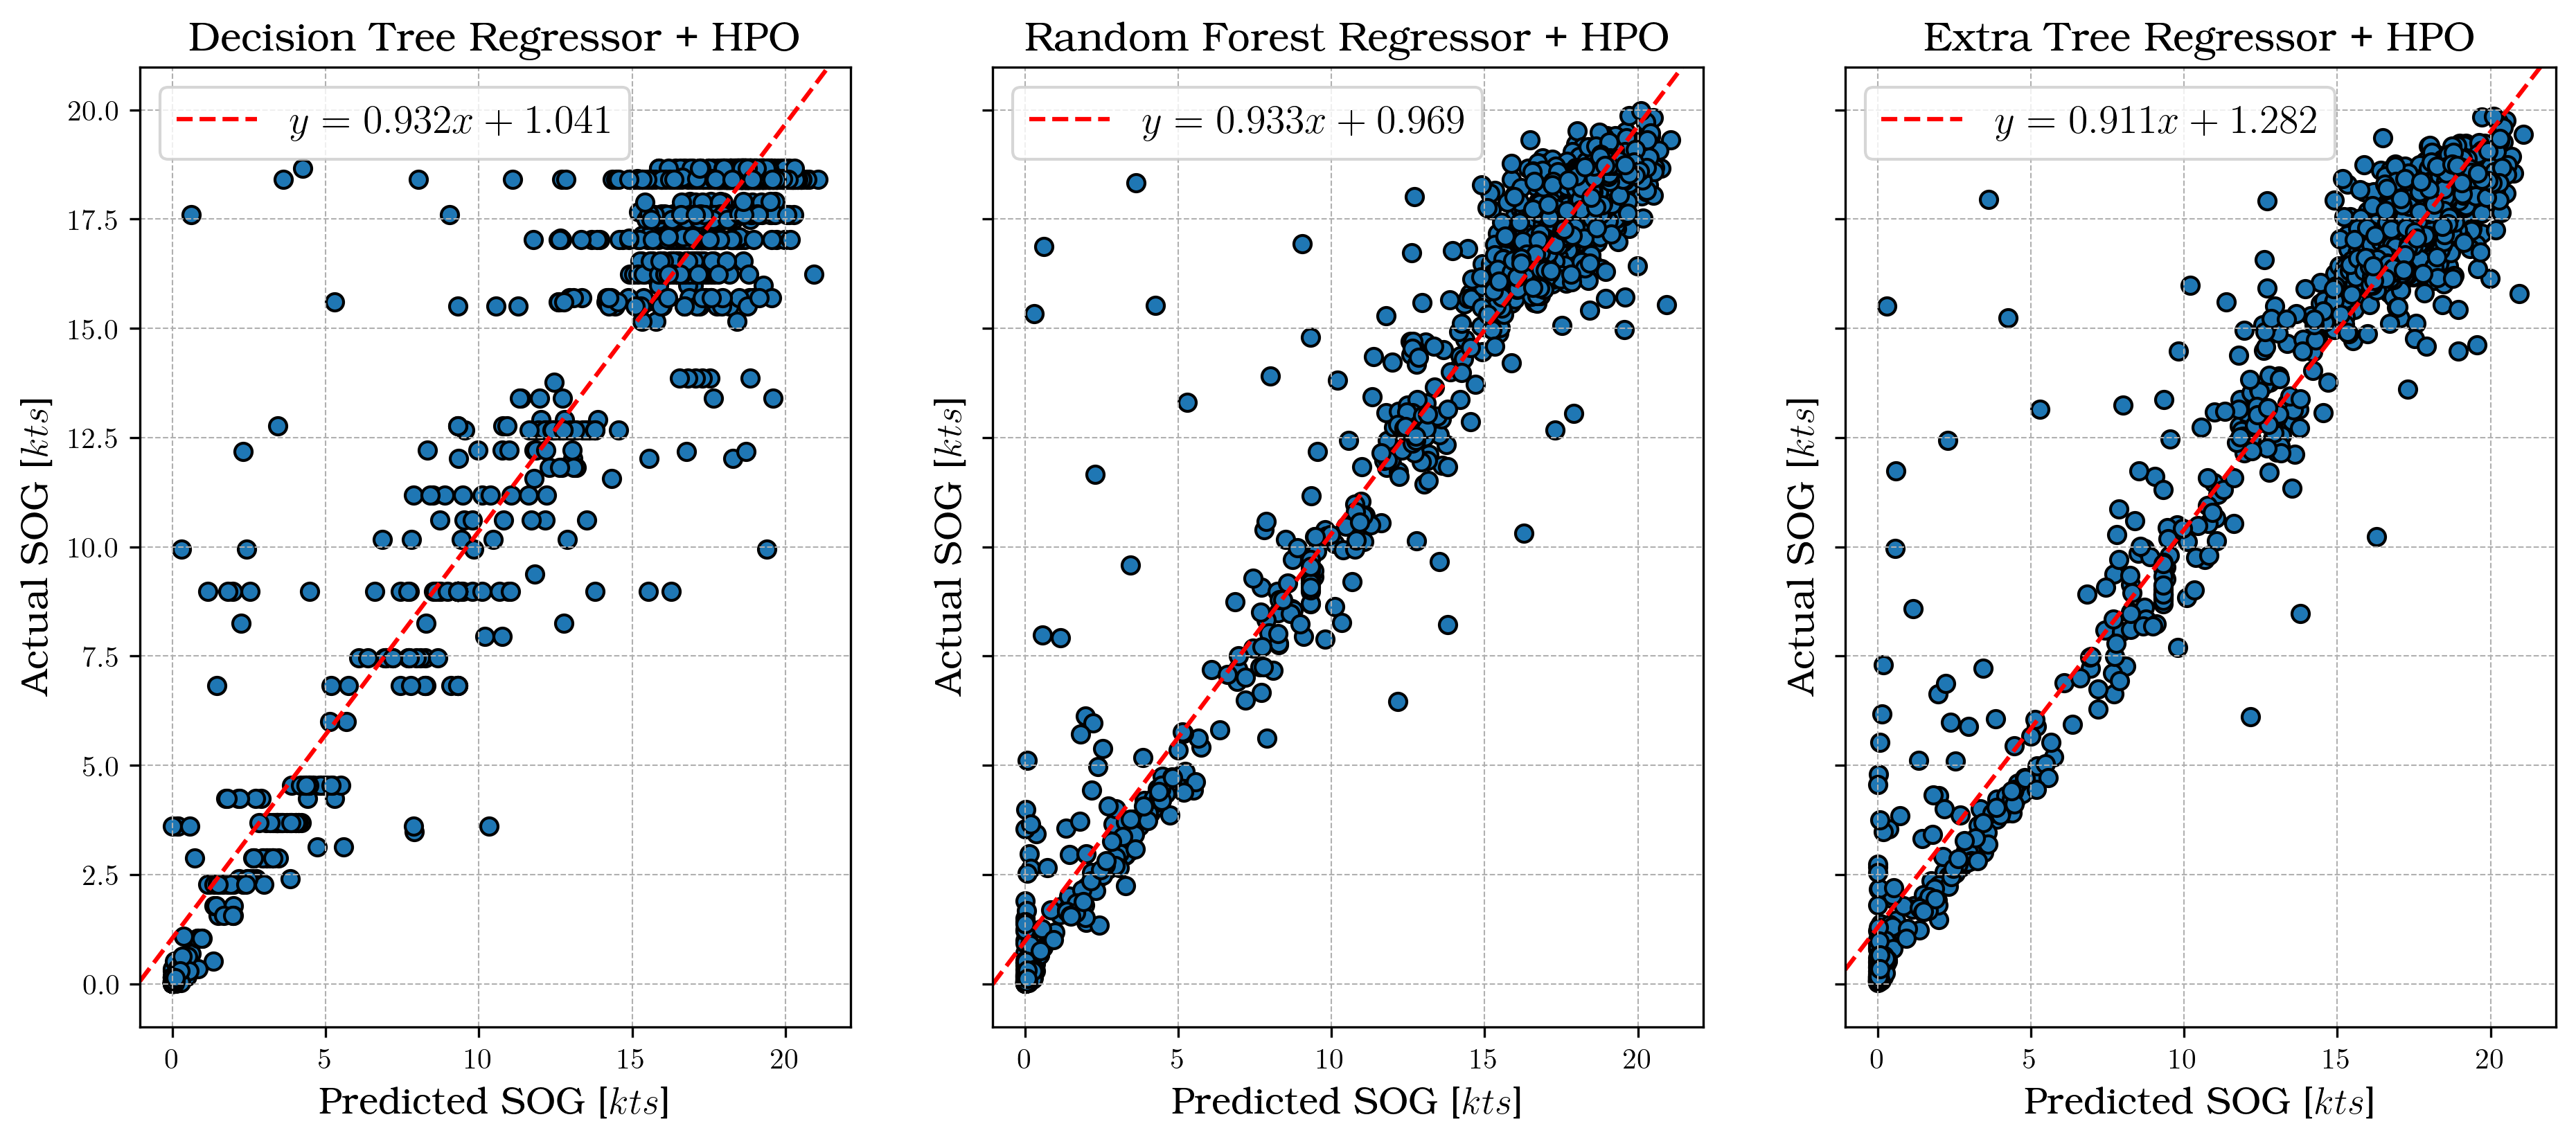

In [212]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 6), sharey=True)
plt.sca(axes[0])
pred_plot(model_dtr_hpov,'Decision Tree Regressor + HPO',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_rfr_hpov,'Random Forest Regressor + HPO',x_date_yr,y_date_yr)
plt.sca(axes[2])
pred_plot(model_etr_hpov,'Extra Tree Regressor + HPO',x_date_yr,y_date_yr)
plt.show()

0.9211020302054139
y = 1.0 * x + 0.6
0.9289504265576506
y = 0.9 * x + 1.0


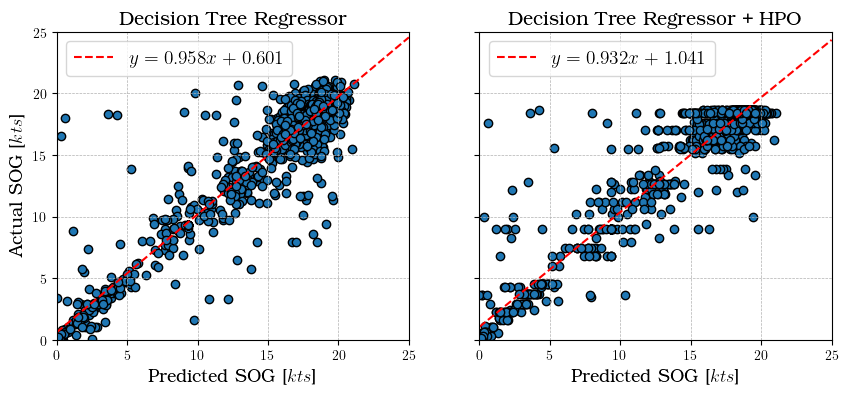

In [146]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_dtr_ftr,'Decision Tree Regressor',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_dtr_hpov,'Decision Tree Regressor + HPO',x_date_yr,y_date_yr)
plt.ylabel("")
plt.show()

0.9581455864193557
y = 1.0 * x + 0.7
0.9541851539649099
y = 0.9 * x + 1.0


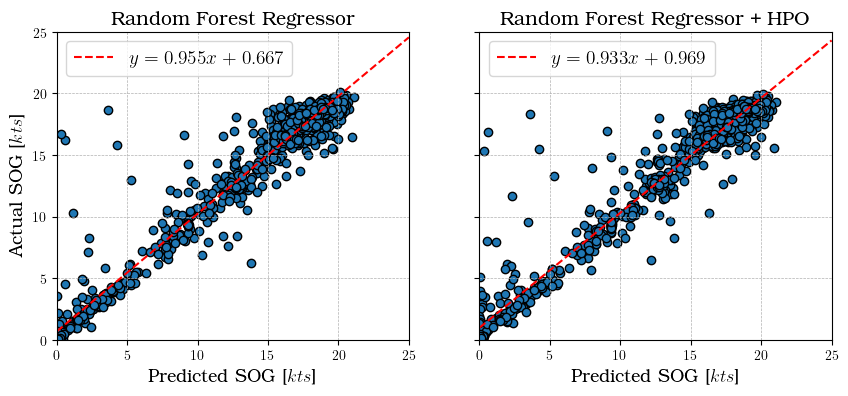

In [147]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_rfr_ftr,'Random Forest Regressor',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_rfr_hpov,'Random Forest Regressor + HPO',x_date_yr,y_date_yr)
plt.ylabel("")
plt.show()

0.9631127774970476
y = 1.0 * x + 0.7
0.9514931190957533
y = 0.9 * x + 1.3


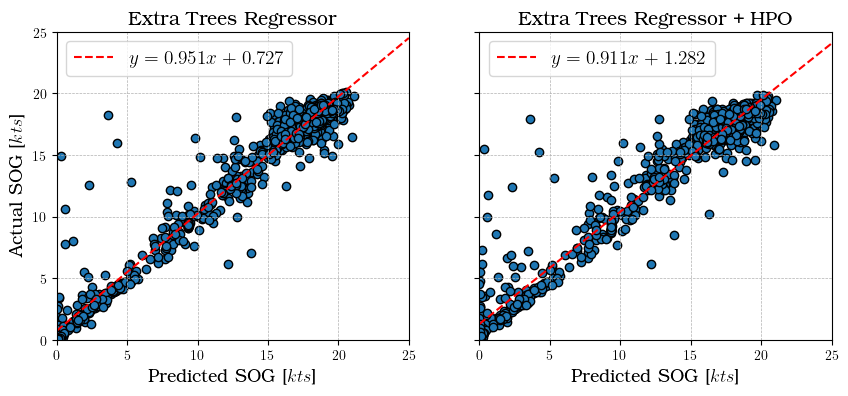

In [148]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_etr,'Extra Trees Regressor',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_etr_hpov,'Extra Trees Regressor + HPO',x_date_yr,y_date_yr)
plt.ylabel("")
plt.show()

### Conversion to STW 
+ Considered only effect of current per [Kim20b](https://doi.org/10.1016/j.ijnaoe.2020.03.007)

In [149]:
def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

#Test data

# ETR
ydate_pred_s = label_predict(model_etr_hpov,x_date_s)
ydate_pred_w = label_predict(model_etr_hpov,x_date_w)
ydate_pred_yr = label_predict(model_etr_hpov,x_date_yr)

# RFR
ydate_pred_rf_s = label_predict(model_rfr_hpov,x_date_s)
ydate_pred_rf_w = label_predict(model_rfr_hpov,x_date_w)
ydate_pred_rf_yr = label_predict(model_rfr_hpov,x_date_yr)


# DTR
ydate_pred_dt_s = label_predict(model_dtr_hpov,x_date_s)
ydate_pred_dt_w = label_predict(model_dtr_hpov,x_date_w)
ydate_pred_dt_yr = label_predict(model_dtr_hpov,x_date_yr)

# MLR  
ydate_pred_mlr_s = label_predict(model_mlr_ftr,x_date_s)
ydate_pred_mlr_w = label_predict(model_mlr_ftr,x_date_w)
ydate_pred__mlr_yr = label_predict(model_mlr_ftr,x_date_yr)


# For actual results

# Yearly dataset

dfprog_sog_yr = pd.Series(y_date_yr,name="sog_act_yr").to_frame()
ydate_pred_yr = label_predict(model_etr_hpov,x_date_yr)
ydate_pred_rf_yr = label_predict(model_rfr_hpov,x_date_yr)
ydate_pred_dt_yr = label_predict(model_dtr_hpov,x_date_yr)
ydate_pred_mlr_yr = label_predict(model_mlr_ftr,x_date_yr)
dfprog_sog_yr["sog_pred_yr"] = ydate_pred_yr
dfprog_sog_yr["sog_pred_rf_yr"] = ydate_pred_rf_yr
dfprog_sog_yr["sog_pred_dt_yr"] = ydate_pred_dt_yr
dfprog_sog_yr["sog_pred_mlr_yr"] = ydate_pred_mlr_yr
dfprog_sog_yr["gamma_yr"] = dfyear["truenorthcurrentdir"]
dfprog_sog_yr["nwinddir_yr"] = dfyear["truenorthwinddir"]
dfprog_yr = pd.concat([x_date_yr,dfprog_sog_yr],axis=1)


# Winter dataset
dfprog_sog_w = pd.Series(y_date_w,name="sog_act_w").to_frame()
ydate_pred_w = label_predict(model_etr_hpov,x_date_w)
ydate_pred_rf_w = label_predict(model_rfr_hpov,x_date_w)
ydate_pred_dt_w = label_predict(model_dtr_hpov,x_date_w)
ydate_pred_mlr_w = label_predict(model_mlr_ftr,x_date_w)
dfprog_sog_w["sog_pred_w"] = ydate_pred_w
dfprog_sog_w["sog_pred_rf_w"] = ydate_pred_rf_w
dfprog_sog_w["sog_pred_dt_w"] = ydate_pred_dt_w
dfprog_sog_w["sog_pred_mlr_w"] = ydate_pred_mlr_w
dfprog_sog_w["gamma_w"] = dfwinter["truenorthcurrentdir"]
dfprog_sog_w["nwinddir_w"] = dfwinter["truenorthwinddir"]
dfprog_w = pd.concat([x_date_w,dfprog_sog_w],axis=1)

# Summer Dataset
dfprog_sog_s = pd.Series(y_date_s,name="sog_act_s").to_frame()
ydate_pred_s = label_predict(model_etr_hpov,x_date_s)
ydate_pred_rf_s = label_predict(model_rfr_hpov,x_date_s)
ydate_pred_dt_s = label_predict(model_dtr_hpov,x_date_s)
ydate_pred_mlr_s = label_predict(model_mlr_ftr,x_date_s)
dfprog_sog_s["sog_pred_s"] = ydate_pred_s
dfprog_sog_s["sog_pred_rf_s"] = ydate_pred_rf_s
dfprog_sog_s["sog_pred_dt_s"] = ydate_pred_dt_s
dfprog_sog_s["sog_pred_mlr_s"] = ydate_pred_mlr_s
dfprog_sog_s["gamma_s"] = dfsummer["truenorthcurrentdir"]
dfprog_sog_s["nwinddir_s"] = dfsummer["truenorthwinddir"]
dfprog_s = pd.concat([x_date_s,dfprog_sog_s],axis=1)


In [150]:
dfprog_yr.describe()

,oceantemperature,waveheight,swellperiod,windwaveperiod,waveperiod,surftemp,windwaveswellheight,swellheight,windwaveheight,draught,...,truenorthcurrentdir,rho_air_ao,p_seasurf,sog_act_yr,sog_pred_yr,sog_pred_rf_yr,sog_pred_dt_yr,sog_pred_mlr_yr,gamma_yr,nwinddir_yr
count,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1.430000e+03,1430.000000,...,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1309.000000,1309.000000
mean,282.863393,1.585584,4.232849,3.408819,3.797357,283.779423,0.831898,0.383140,6.699215e-01,5.176948,...,154.402393,1.242634,101338.205726,14.270611,14.280071,14.285684,14.338292,14.444128,153.990813,193.634499
std,6.587627,1.104158,1.020194,0.943869,0.896033,5.884230,0.565310,0.188647,5.916107e-01,0.219256,...,97.506604,0.033032,986.644412,6.407961,5.977648,6.119970,6.194503,5.202198,101.764140,92.720467
min,266.114777,0.107192,1.967748,1.570717,1.967748,273.048584,0.070604,0.070659,2.507146e-16,4.700000,...,0.281785,1.170450,97178.312500,0.000273,0.029981,0.003790,0.007829,-3.294274,0.281785,0.121903
25%,277.200134,0.763643,3.502174,2.728874,3.161146,278.317383,0.410441,0.256724,2.164307e-01,5.000000,...,78.603379,1.215066,100724.015625,12.225047,12.949000,12.439003,12.678667,14.293165,75.040185,130.912666
50%,282.897949,1.341774,4.179894,3.364497,3.715221,283.468018,0.708183,0.350363,5.396818e-01,5.200000,...,141.047705,1.241388,101469.562500,17.344856,17.148364,17.281631,17.493493,16.319999,127.051605,197.915801
75%,288.996826,2.075973,4.881524,3.864906,4.351968,289.384521,1.087195,0.464980,9.279484e-01,5.313617,...,218.553816,1.268963,101991.750000,18.590115,18.249522,18.396947,18.413185,16.905996,240.618627,273.910704
max,297.026611,7.311599,7.517778,7.092444,7.085897,295.046387,3.780643,2.209327,3.732544e+00,5.700000,...,359.532314,1.348105,103961.562500,21.070492,19.858422,19.975331,18.671655,33.254395,359.532314,359.236303


In [151]:
dfprog_w.describe()

,oceantemperature,waveheight,swellperiod,windwaveperiod,waveperiod,surftemp,windwaveswellheight,swellheight,windwaveheight,draught,...,truenorthcurrentdir,rho_air_ao,p_seasurf,sog_act_w,sog_pred_w,sog_pred_rf_w,sog_pred_dt_w,sog_pred_mlr_w,gamma_w,nwinddir_w
count,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,6.850000e+02,685.000000,...,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,564.000000,564.000000
mean,277.061812,1.798823,4.516535,3.515747,4.023006,278.487116,0.941657,0.425647,7.693292e-01,5.159203,...,154.643071,1.269975,101318.987865,14.251250,14.271006,14.271618,14.320395,14.410141,153.743626,193.196078
std,3.281621,1.113793,0.975649,0.967864,0.876633,2.419024,0.572970,0.208538,5.978353e-01,0.212482,...,91.031734,0.021881,1140.346944,6.486222,6.002640,6.135490,6.209032,5.272028,99.772476,101.360080
min,266.114777,0.176935,2.036522,1.603139,2.011009,273.048584,0.111497,0.109539,2.536182e-16,4.700000,...,0.587267,1.206596,97178.312500,0.000275,0.029366,0.003894,0.007829,-3.294274,0.587267,0.121903
25%,275.052979,0.995592,3.913634,2.833595,3.455495,276.691162,0.531084,0.291962,3.247070e-01,5.000000,...,82.113261,1.255830,100526.812500,12.402381,12.987462,12.268214,12.175370,14.160499,73.626497,124.347057
50%,277.048340,1.581527,4.451812,3.435428,3.948828,278.137695,0.832892,0.389038,6.728522e-01,5.200000,...,155.264861,1.270367,101534.125000,17.480699,17.292967,17.406397,17.604233,16.306319,136.204115,200.807967
75%,279.242920,2.329129,5.069295,4.022782,4.478737,279.446045,1.215751,0.506405,1.064692e+00,5.300000,...,204.541457,1.281857,102150.062500,18.564720,18.116153,18.274000,18.413185,16.889789,237.748606,278.265539
max,286.223145,7.311599,7.517778,7.092444,7.085897,284.604492,3.780643,2.209327,3.732544e+00,5.700000,...,359.532314,1.348105,103961.562500,20.935750,19.193418,19.271541,18.671655,33.254395,359.532314,359.236303


In [152]:
dfprog_s.describe()

,oceantemperature,waveheight,swellperiod,windwaveperiod,waveperiod,surftemp,windwaveswellheight,swellheight,windwaveheight,draught,...,truenorthcurrentdir,rho_air_ao,p_seasurf,sog_act_s,sog_pred_s,sog_pred_rf_s,sog_pred_dt_s,sog_pred_mlr_s,gamma_s,nwinddir_s
count,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,7.450000e+02,745.000000,...,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000
mean,288.197733,1.390462,3.976440,3.309675,3.593307,288.579985,0.731450,0.344540,5.788171e-01,5.193264,...,154.177945,1.217824,101355.875839,14.288412,14.286935,14.296851,14.343317,14.483209,154.177945,193.966404
std,3.737520,1.059116,0.995456,0.910226,0.865965,3.650382,0.539489,0.159412,5.714660e-01,0.224210,...,103.312733,0.019527,820.709333,6.339460,5.962712,6.110707,6.193155,5.137977,103.312733,85.671055
min,278.347168,0.107192,1.967748,1.570717,1.967748,278.303833,0.070604,0.070659,2.507146e-16,4.700000,...,0.281785,1.170450,97801.812500,0.000273,0.037769,0.003923,0.007829,-1.441432,0.281785,2.695914
25%,285.557861,0.614089,3.238856,2.610878,2.930254,286.375704,0.334487,0.228644,1.396484e-01,5.000000,...,77.183839,1.202929,100862.062500,12.154439,12.944706,12.483567,12.678667,14.351070,77.183839,137.784279
50%,288.854492,1.120069,3.923565,3.240900,3.495082,289.280640,0.596299,0.317474,4.406281e-01,5.200000,...,124.537310,1.215619,101432.437500,17.215356,17.047140,17.122353,17.493493,16.371624,124.537310,195.253913
75%,290.984131,1.824555,4.622211,3.864882,4.108571,291.372437,0.956096,0.425568,8.087105e-01,5.400000,...,244.680402,1.232815,101870.875000,18.634934,18.372729,18.542120,18.413185,16.937814,244.680402,271.464496
max,297.026611,5.793899,6.992472,6.188758,6.191917,295.046387,2.950672,1.152069,2.884644e+00,5.700000,...,359.450078,1.266453,103640.750000,21.070492,19.858422,19.975331,18.671655,32.347023,359.450078,358.771465


In [153]:
# # Ignore for latex export
# print(dfprog_sog_s.describe())
# print(dfprog_sog_s.describe().transpose().to_latex(index=False,

#                   formatters={"name": str.upper},

#                   float_format="{:.2f}".format,

# ))  

+ Boxplots showcasing the skew of the SOG

<Figure size 500x300 with 0 Axes>

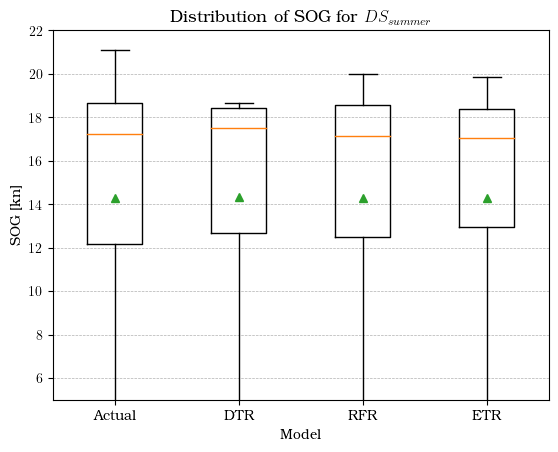

In [154]:
# Box plot of predicted results of winter dataset

plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores = [dfprog_sog_s['sog_act_s'],dfprog_sog_s['sog_pred_dt_s'],dfprog_sog_s['sog_pred_rf_s'],dfprog_sog_s['sog_pred_s']]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title(r"Distribution of SOG for $DS_{summer}$")
plt.ylabel("SOG [kn]")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(5,22)
plt.boxplot(scores,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['Actual', 'DTR',
                    'RFR', 'ETR'])
plt.show()

In [155]:
# # Ignore for latex export
# print(dfprog_sog_w.describe())
# print(dfprog_sog_w.describe().transpose().to_latex(index=False,

#                   formatters={"name": str.upper},

#                   float_format="{:.2f}".format,

# )) 

<Figure size 500x300 with 0 Axes>

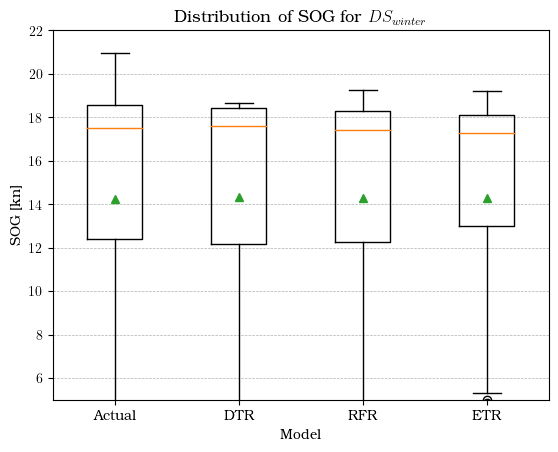

In [156]:
# Box plot of predicted results of winter dataset

plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores = [dfprog_sog_w['sog_act_w'],dfprog_sog_w['sog_pred_dt_w'],dfprog_sog_w['sog_pred_rf_w'],dfprog_sog_w['sog_pred_w']]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title(r"Distribution of SOG for $DS_{winter}$")
plt.ylabel("SOG [kn]")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(5,22)
plt.boxplot(scores,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['Actual', 'DTR',
                    'RFR', 'ETR'])
plt.show()

In [157]:
# # Ignore for latex export
# print(dfprog_sog_yr.describe())
# print(dfprog_sog_yr.describe().transpose().to_latex(index=False,

#                   formatters={"name": str.upper},

#                   float_format="{:.2f}".format,

# )) 

<Figure size 500x300 with 0 Axes>

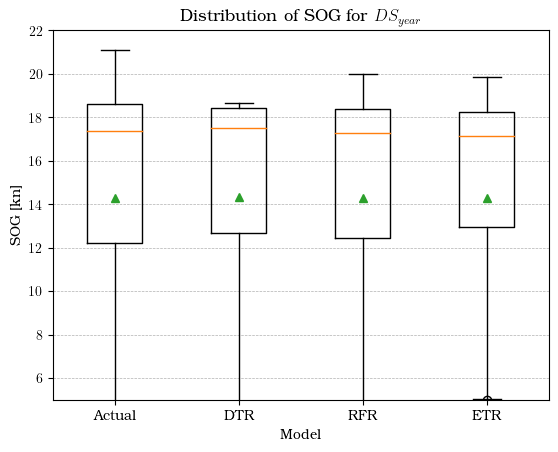

In [158]:
# Box plot of predicted results of yearly dataset

plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores = [dfprog_sog_yr['sog_act_yr'],dfprog_sog_yr['sog_pred_dt_yr'],dfprog_sog_yr['sog_pred_rf_yr'],dfprog_sog_yr['sog_pred_yr']]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title(r"Distribution of SOG for $DS_{year}$")
plt.ylabel("SOG [kn]")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(5,22)
plt.boxplot(scores,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['Actual', 'DTR',
                    'RFR', 'ETR'])
plt.show()

Formula for STW correction

In [159]:
def sog_corr(sog,gamma,heading,current_speed):
    # Conversion of predicted SOG to m/s
    vgms = sog/1.9438
    rad_gamma = np.deg2rad(gamma)
    rad_cog = np.deg2rad(heading)
    # Calculation of the predicted x-component of SOG

    vgx = vgms * np.sin(rad_cog)
    vcx = current_speed * np.sin(rad_gamma)
    stw_x = vgx - vcx

    # Calculation of the predicted y-component of SOG 

    vgy = vgms * np.cos(rad_cog)
    vcy = current_speed * rad_gamma
    stw_y = vgy - vcy

    vwms_p = np.sqrt(stw_x**2 + stw_y**2)
    stw_pred = vwms_p*1.9438

    return stw_pred

In [160]:
# STW conversion Year

# Actual
stw_act_yr = sog_corr(dfprog_yr['sog_act_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_act_yr'] = stw_act_yr
# ETR
stw_pred_et_yr = sog_corr(dfprog_yr['sog_pred_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_yr'] = stw_pred_et_yr
# RFR
stw_pred_rf_yr = sog_corr(dfprog_yr['sog_pred_rf_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_rf_yr'] = stw_pred_rf_yr
# DTR
stw_pred_dt_yr = sog_corr(dfprog_yr['sog_pred_dt_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_dt_yr'] = stw_pred_dt_yr
# MLR
stw_pred_mlr_yr = sog_corr(dfprog_yr['sog_pred_mlr_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_mlr_yr'] = stw_pred_mlr_yr



In [161]:
print(dfprog_yr.describe())

       oceantemperature   waveheight  swellperiod  windwaveperiod  \
count       1430.000000  1430.000000  1430.000000     1430.000000   
mean         282.863393     1.585584     4.232849        3.408819   
std            6.587627     1.104158     1.020194        0.943869   
min          266.114777     0.107192     1.967748        1.570717   
25%          277.200134     0.763643     3.502174        2.728874   
50%          282.897949     1.341774     4.179894        3.364497   
75%          288.996826     2.075973     4.881524        3.864906   
max          297.026611     7.311599     7.517778        7.092444   

        waveperiod     surftemp  windwaveswellheight  swellheight  \
count  1430.000000  1430.000000          1430.000000  1430.000000   
mean      3.797357   283.779423             0.831898     0.383140   
std       0.896033     5.884230             0.565310     0.188647   
min       1.967748   273.048584             0.070604     0.070659   
25%       3.161146   278.317383  

In [162]:
# STW conversion Summer 

# Actual
stw_act_s = sog_corr(dfprog_s['sog_act_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_act_s'] = stw_act_s
# ETR
stw_pred_et_s = sog_corr(dfprog_s['sog_pred_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_s'] = stw_pred_et_s
# RFR
stw_pred_rf_s = sog_corr(dfprog_s['sog_pred_rf_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_rf_s'] = stw_pred_rf_s
# DTR
stw_pred_dt_s = sog_corr(dfprog_s['sog_pred_dt_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_dt_s'] = stw_pred_dt_s
# MLR
stw_pred_mlr_s = sog_corr(dfprog_s['sog_pred_mlr_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_mlr_s'] = stw_pred_mlr_s



In [163]:
print(dfprog_s.describe())

       oceantemperature  waveheight  swellperiod  windwaveperiod  waveperiod  \
count        745.000000  745.000000   745.000000      745.000000  745.000000   
mean         288.197733    1.390462     3.976440        3.309675    3.593307   
std            3.737520    1.059116     0.995456        0.910226    0.865965   
min          278.347168    0.107192     1.967748        1.570717    1.967748   
25%          285.557861    0.614089     3.238856        2.610878    2.930254   
50%          288.854492    1.120069     3.923565        3.240900    3.495082   
75%          290.984131    1.824555     4.622211        3.864882    4.108571   
max          297.026611    5.793899     6.992472        6.188758    6.191917   

         surftemp  windwaveswellheight  swellheight  windwaveheight  \
count  745.000000           745.000000   745.000000    7.450000e+02   
mean   288.579985             0.731450     0.344540    5.788171e-01   
std      3.650382             0.539489     0.159412    5.714660e-0

In [164]:
# STW conversion Winter

# Actual
stw_act_w = sog_corr(dfprog_w['sog_act_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_act_w'] = stw_act_w
# ETR
stw_pred_et_w = sog_corr(dfprog_w['sog_pred_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_w'] = stw_pred_et_w
# RFR
stw_pred_rf_w = sog_corr(dfprog_w['sog_pred_rf_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_rf_w'] = stw_pred_rf_w
# DTR
stw_pred_dt_w = sog_corr(dfprog_w['sog_pred_dt_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_dt_w'] = stw_pred_dt_w
# MLR
stw_pred_mlr_w = sog_corr(dfprog_w['sog_pred_mlr_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_mlr_w'] = stw_pred_mlr_w

Holtrop Mennen FOC function

In [165]:
def foc_fun(stw,T_dyn,windspeed,truewindir,H_s,truewavedir):
    # Ship Information, that are readily available in ship specification
    loa = 158 # ship overall length
    lwl = 144.8 # ship waterline length, m
    lpp = 0.97*lwl # ship perpendicular length , m, according to information
    B = 24.5 # Ship breadth, m
    depth = 13.8 # Ship depth. m
    T_n = 5.85 # Nominal max draught , m
    # T_n = 5.7 # Nominal design draught , m
    dwt = 5110 # ship dead weight , t
    V_n = 17.7 # ship design speed, knots
    # V_n = 18 # ship design speed, knots


    # Environmental Constants

    g = 9.805 # gravity, kg/ms^2 
    rho_sea = 1025 # kg/m3
    nu_sea = 0.00000118 # Dynamic viscosity of sea m^2/s
    rho_air = 1.25 # density air 

    # Any other additional ship parameters beyond here are approximated based on literature review.

    # Convert STW to m/s, stw with only current correction

    stw_ms = stw / 1.94384

    # Switch between actual and predicted here 
    # Calculation for Block coefficient,C_b, according to Schneekluth and Bertram 1998
    # Then Froude number is required

    V_n = 17.7/1.94384
    # V_n = 18/1.94384

    Fr_n = V_n / math.sqrt(g*lwl)
    # print(f"Froude Number {Fr_n:0.4f}")

    C_b = -4.22 + 27.8*math.sqrt(Fr_n) - 39.1*Fr_n + 46.6*(Fr_n)**3
    # print(f"C_b {C_b:0.4f}")

    # calculation for midship section coefficient, C_m according to Jensen from Birk

    C_m = 1 / (1+(1-C_b)**3.5)
    # print(f"C_m {C_m:0.4f}")

    # prismatic coefficient C_p can be calculated according to Biran

    C_p = C_b/C_m 
    # print(f"C_p {C_p:0.4f}")

    # Displacement calculation according to Barras 

    dsp = C_b * lwl * B * T_n

    # print(f"dsp {dsp:0.4f} m^3")

    # coefficient c14 to account for stern shape according to holtrop mennen

    C_stern = 10 # assume u shaped stern
    c14 = 1 + 0.011*C_stern 
    
    # print(f"c14 {c14:0.4f}")

    # Calculate length of run according to holtrop mennen

    # lcb = -2/100 # according to Barras
    lcb = -(0.44*Fr_n - 0.094) # according to Guldhammer and Harvald

    # print(f"lcb {lcb:0.4f}")

    # L in holtrop mennen is lwl

    lr = lwl*(1-C_p+(0.06*C_p*lcb/(4*C_p-1)))

    # print(f"lr {lr:0.4f} m")

    # now the (1+k1) can be calculated

    k1a = 0.487118*c14*(B/lwl)**1.06806
    k1b = (T_dyn/lwl)**0.46106
    k1c = (lwl/lr)**0.121563
    k1d = (lwl**3/dsp)**0.36486
    k1e = (1-C_p)**-0.604247

    k1_const = 0.93 + k1a*k1b*k1c*k1d*k1e

    # print(f"k1_const {k1_const.mean():0.4f}")

    # Calculate Reynold number and Coefficient of Friction C_f. Here, the C_f will be dynamic and depend on the velocity of the ship

    Re =( stw_ms * lwl ) / nu_sea
    C_f = 0.075 / (np.log10(Re-2)**2)

    # print(f"Mean Reynold Number {Re.mean():0.2f}")
    # print(f"Mean Coefficient of friction {C_f.mean():0.6f}")
    
    # Calculate the appendage area of bare hull S_bh
    # Formula according to Holtrop Mennen

    # Calculate the waterplane area coefficient 
    # Formula according to Schneekluth and Bertram

    C_wp = (1+2*C_b)/3
    # print(f"C_wp {C_wp:0.4f}")

    # Calculate transverse bulb area A_bt, Transom area A_t and immersed midship section area A_m according to Kim 2019

    # dfprog['A_m'] = B*dfprog['draught']*C_m
    # Borrow estimation of Am from Guldahmmer and Harvald
    A_m = dsp/(lpp*C_p)
    A_t = 0.051 * A_m
    A_bt = 0.085*A_m # From approximation of Kracht78, Similar to Charcalis
    # print(f"A_m {A_m:0.2f} m^2")
    # print(f"A_t {A_t:0.4f} m^2")
    # print(f"A_bt {A_bt:0.4f} m^2")

    sbh_a = lwl*(2*T_dyn+B)*math.sqrt(C_m)
    sbh_b = 0.453
    sbh_c = 0.4425*C_b
    sbh_d = 0.2862*C_m
    sbh_e = 0.003467*(B/T_dyn)
    sbh_f = 0.3696*C_wp
    sbh_g = 2.38*A_bt/C_b

    S_bh = sbh_a*(sbh_b+sbh_c-sbh_d+sbh_e+sbh_f)+sbh_g

    # print(f"S_bh {S_bh.mean():0.4f} m^2")

    # Calculate R_f

    R_f = 0.5 * rho_sea * stw_ms**2 * C_f * S_bh * k1_const

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Frictional Resistance {R_f.mean():0.2f} N")
    
    # Calculate resistance due to appendage

    # Assume S_app
    # Taken from Holtrop Mennen worked example
    # S_app = 50 # m^2 

    # Calculation of appendage area according to Hollenbach method, the formula is for twin screw ship

    # Lower limit
    S_app_lo = S_bh.mean()*(0.028+0.01*math.exp(-(lpp*T_n)/1000))

    # Upper limit
    S_app_hi = S_bh.mean()*(0.0325+0.045*math.exp(-(lpp*T_n)/1000))

    # print(f"S_app between {S_app_lo:.02f} and {S_app_hi:.02f} according to Hollenbach")

    # The following appendage area are scaled from the picture of the ship
    # Constant k here means (1+k_2) !

    D_shaft = 0.55 # m, approx
    l_shaft = 13.54 # m, approx

    S_app_shaft = 2*math.pi * D_shaft * l_shaft
    k2_shaft = 3   

    h_rudder = 4.06 #m, approx
    B_rudder = 1.99 #m, approx
    S_app_rudder = 2 * h_rudder * B_rudder #m, two side
    k2_rudder = 3

    h_skeg = 4.41 #m, approx
    l_skeg = 26.23 #m, approx
    S_app_skeg =  h_skeg * l_skeg #two side (triangle)
    k2_skeg = 1.5

    S_app = S_app_shaft + S_app_rudder + S_app_skeg

    k2_const = (k2_shaft*S_app_shaft + k2_rudder*S_app_rudder + k2_skeg*S_app_skeg)/S_app

    # print(f"Wetted area of hull is {S_bh.mean():0.2f}")
    # print(f"(1+k2) equivalent {k2_const:0.2f}")
    # print(f"Total Appendage area is {S_app:0.4f}")
    # # from holtrop mennen, take case of twin screw
    # k2_const = 2.8

    # Add resistance due to Bow Thrusters

    d_th = 2.15 #m, approx

    # Use formula from Hollenach
    C_dth = 0.003 + 0.003*((10*d_th/T_n)-1)
    # C_dth = 0.003 # The picture shows that the thruster are fairly parallel to midship area
    # There are two bow thruster in this ship
    R_th = rho_sea*stw_ms**2*math.pi*d_th**2*C_dth

    # print(f"Friction due to bow thrusters {R_th.mean():0.2f} N")

    R_app = (0.5 * rho_sea * stw_ms**2 * C_f * S_app *k2_const) + 2*R_th

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Appendage Friction {R_app.mean():0.2f} N")

    # Calculate wave-making and wave-breaking resistance

    # print("Ratio check to ensure correct formula is used for Holtrop Mennen")
    # print(f"B/lwl = {B/lwl:0.2f}")
    # print(f"lwl^3/displacemt = {lwl**3/dsp:0.2f}")
    # print(f"C_p = {C_p:0.4f}")


    c7 = B/lwl
    T_fwd = T_dyn # See reasoning from Rakke16 
    h_b = 0.6*T_n # must not exceed 0.6 T_f, here T_n = T_f (design), reasong and coefficient value taken from Rakke
    
    # print(f"h_B {h_b:0.4f}")

    # All formulas here are listed by Holtrop Mennen

    c3 = 0.56 * A_bt**1.5 / (B*T_dyn*(0.31*np.sqrt(A_bt)+T_fwd-h_b))
    c2 = np.exp(-1.89*np.sqrt(c3))
    c5 = 1 - 0.8*(A_t/(B*T_dyn*C_m))
    lambda_const = (1.446 * C_p) - 0.03*(lwl/B)
    c16 = 8.07981*C_p - 13.8673*C_p**2 + 6.984388*C_p**3
    m_1 = 0.0140407 * (lwl/T_dyn) - 1.75254*(dsp**(1/3)/lwl) -  4.79323*(B/lwl) - c16
    c15 = -1.69385

    # Use dynamic Froude here to refect the actual resistance due to ship movement 

    Fr_n_dyn = stw_ms / math.sqrt(g*lwl)
    # Updated formula use m_4
    m4 = 0.4 * c15 * np.exp(-0.034*Fr_n_dyn **-3.29)

    i_e = 1 + 89*math.exp(-(lwl/B)**0.80856*(1-C_wp)**0.30484*(1-C_p-0.0225*lcb)**0.6367*(lr/B)**0.34574*((100*dsp)/lwl**3)**0.16302)
    c1 = 2223105 * c7**3.78613 * (T_dyn/B)**1.07961*(90-i_e)**-1.37565
    d = -0.9

    # print(f"i_e = {i_e:0.4f}")

    # Use updated formula with m4

    R_w = c1*c2*c5*dsp*g*rho_sea*np.exp(m_1*Fr_n_dyn **d+m4*np.cos(lambda_const*Fr_n_dyn **-2))

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Wave resistance {R_w.mean():0.2f} N")

    # Calculate Resistance due to Bulbous Bow
    # Calculate effect of forward sinkage h_f and local wave height at bow h_w

    P_b = 0.56*np.sqrt(A_bt)/(T_fwd-1.5*h_b)
    Fn_i = stw_ms / np.sqrt(g*(T_fwd-h_b-0.25*np.sqrt(A_bt))+0.15*stw_ms**2)
    R_b = 0.11 * np.exp(-3*P_b**-2)*Fn_i**3*A_bt**1.5*rho_sea*g/(1+Fn_i**2)

    # print(f"Emergence of bulb Pb {P_b.mean():0.4f}")
    # print(f"Immersion Froude number Fn_i {Fn_i.mean():0.2f}")
    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Resistance due to bulbous bow {R_b.mean():0.2f} N")    

    #Calculate Transom Resistance 

    Fn_tr = stw_ms / np.sqrt(2*g*A_t/(B+(B*C_wp)))

    # print(f"Froude for Transom {Fn_tr.mean():0.4f}")

    # Use condition to calculate Froude due to transom

    cond_Fn_tr = [Fn_tr < 5 ]
    cond_c6 = [0.2*(1-0.2*Fn_tr)]

    c6 = np.select(cond_Fn_tr,cond_c6,0)
    R_tr = 0.5*rho_sea*10**2*A_t*c6

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Resistance due to transom {R_tr.mean():0.2f} N")

    # Model ship correlation resistance

    # print("Ratio check to ensure correct formula is used for Holtrop Mennen")

    cond_Tf_lwl = [(T_fwd/lwl) <= 0.04 ]
    cond_c4 = [T_fwd/lwl]
    c4 = np.select(cond_Tf_lwl,cond_c4,0.04)

    C_a = 0.00546*(lwl+100)**-0.16 - 0.002 + 0.003*math.sqrt(lwl/7.5)*C_b**4*c2*(0.04-c4)

    R_a = 0.5*rho_sea*stw_ms**2*C_a*(S_bh+S_app)

    # print(f"C_a {C_a.mean()}")
    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Correlation allowance resistance {R_a.mean():0.2f} N")

    # Calculate Additional Resistance, consist of wind resistance and wave resistance
    # Calculate Apparent velocities and Apparent Angle 

    V_aw = np.sqrt(windspeed**2 + stw_ms**2 + 2*windspeed*stw_ms*np.cos(np.deg2rad(truewindir)))

    awa_c1 = (windspeed/V_aw)*np.sin(np.deg2rad(truewindir))

    # Epsilon is Apparent Wind Angle AWA

    epsilon = np.rad2deg(np.arcsin(awa_c1))

    # Values and method from Blendermann

    C_DlAf = 0.45
    A_f = 325.3
    A_l = 2125.8
    C_Dt = 0.9
    delta = 0.8
    C_Dl = C_DlAf * A_f / A_l
    L_bwl = 43.75 # m, acquired from picture

    Raa_const1 = (rho_air/2) * V_aw**2 * A_l * C_Dl
    Raa_const2 = np.cos(np.deg2rad(epsilon))
    Raa_const3 = 1 - (delta/2) * ((1-(C_Dl/C_Dt))*(np.sin(np.deg2rad(2*epsilon)))**2)

    R_aa = Raa_const1 * Raa_const2 / Raa_const3 

    # print(f"Mean wind resistance Blendermann {R_aa.mean():0.2f}N")

    # Calculate Wave Resistance according to STAWAVE-1

    Rawl = (1/16) * rho_sea * g * H_s**2 * math.sqrt(B/L_bwl) * B

    condwave = [truewavedir<=45]
    choicewave = [Rawl]

    R_awl = np.select(condwave,choicewave,0)

    # print(f"Mean wave resistance STAWAVE-1 {R_awl.mean():0.2f} N")

    R_tot = (R_f + R_app + R_w + R_b + R_a + R_tr  + R_aa + R_awl)/1e3 

    # Calculate Efficiencies

    # Diameter value for ship estimated from Bertram 

    # D = 0.215*16 #m 
    # Revised D, 08.07.23
    D = 4 # m, from flyer
    PD_const = 1.135  # From Bertram

    # Update C_v formula

    C_v = (k1_const*R_f + R_app + R_a) / (0.5*rho_sea*stw_ms**2*(S_bh+S_app))
    w = 0.3095 * C_b + 10*C_v*C_b - (0.23*D)/np.sqrt(B*T_dyn) 
    t = 0.325*C_b - 0.1885*D/np.sqrt(B*T_dyn)
    eff_h = (1-t) / (1-w)
    eff_r = 0.9737 + 0.111*(C_p - 0.225*lcb) - 0.06325*PD_const
    eff_s = 0.99 # Set according to holtrop mennen and man
    eff_o = 0.7 # Approximation from Wageningen Line from Breslin94, since Holtrop perform their measurement in Wageningen basin 

    eff_tot = eff_h* eff_r* eff_s*eff_o # consider sea margin

    # print(f"Total Efficiency {eff_tot.mean():0.3f}")

    # Calculate power and FOC

    P_b = (R_tot * stw_ms)/eff_tot # in kW
    SFOC = 169.4 # g/kWh, taken from datasheet Waertsilla 8V31
    FOC = (P_b * SFOC)/1e6 # get FOC t/h
    FOC_day = FOC * 11 #Per day 11 hour journey

    # print("Summary of important results")
    
    # print(f"Ship Displacement {dsp:0.4f} m^3")
    # print(f"Prismatic coefficient C_p {C_p:0.4f}")
    # print(f"Midship coefficient C_m {C_m:0.4f}")
    # print(f"Block coefficient C_b {C_b:0.4f}")
    # print(f"Waterplane area constant C_wp {C_wp:0.4f}")
    # print(f"Design Froude Number Fr_n {Fr_n:0.4f}")
    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Max STW {stw.max():0.2f} kt")
    # print(f"Average frictional Resistance R_f {R_f.mean()/1e3:0.3f}kN")
    # print(f"Average appendage friction R_app {R_app.mean()/1e3:0.3f}kN")
    # print(f"Average wave making (calm) resistance R_w {R_w.mean()/1e3:0.3f}kN")
    # print(f"Average bulbous bow resistance R_b {R_b.mean()/1e3:0.3f}kN")
    # print(f"Average transom resistance R_t {R_tr.mean()/1e3:0.3f}kN")
    # print(f"Average model correlation resistance R_a {R_a.mean()/1e3:0.3f}kN")
    # print(f"Average wind resistance (Blendermann) R_aa {R_aa.mean()/1e3:0.3f}kN")
    # print(f"Average wave resistance R_awl {R_awl.mean()/1e3:0.3f}kN")
    # print(f"Average total resistance R_tot {R_tot.mean():0.3f}kN")
    # print(f"Average Total Efficiency {eff_tot.mean():0.3f}")
    # print(f"Average Power {P_b.mean():0.3f} kW")
    # print(f"Max Power {P_b.max():0.3f} kW")
    # print(f"Average Fuel Consumption per hour {FOC.mean():0.3f} T")
    # print(f"Average Fuel Consumption per day {FOC_day.mean():0.3f} T")


    return R_f,R_app,R_w,R_b,R_tr,R_a,R_aa,R_awl,R_tot,eff_tot,P_b,FOC


Comparison of Summer and Winter fuel consumption

Actual Summer

In [166]:
Rf_act_s,R_app_act_s,R_w_act_s,R_b_act_s,R_tr_act_s,R_a_act_s,R_aa_act_s,R_awl_act_s,R_tot_act_s,eff_tot_act_s,P_b_act_s,FOC_act_s = foc_fun(dfprog_s['stw_act_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

In [167]:
def stats_HoltropMennen(stw,RFric,RApp,RWave,RBulb,RTrans,RCorr,RWind,RStaWave,RTot,EffTot,Pbrake,FOChr):
    WBM_desc_stats = pd.concat([stw,RFric/1e3,RApp/1e3,RWave/1e3,RBulb/1e3,pd.Series(RTrans/1e3),RCorr/1e3,RWind/1e3,pd.Series(RStaWave/1e3),RTot,EffTot,Pbrake,FOChr],axis=1)
    WBM_HM_desc = pd.DataFrame(WBM_desc_stats)
    WBM_HM_desc.columns = ['STW [m/s]','R_F [kN]', 'R_APP [kN]', 'R_W [kN]', 'R_B [kN]', 'R_TR [kN]' ,'R_A [kN]', 'R_AA [kN]' , 'R_AWL [kN]', 'R_TOT [kN]' , 'EFF_TOT [-]' ,'P_B[kW]','FOC [T/h]' ]
    # Direct print to LaTex, uncomment if needed
    # print(WBM_HM_desc.describe().transpose().to_latex(index=False,

    #               formatters={"name": str.upper},

    #               float_format="{:.2f}".format,
    # ))
    return WBM_HM_desc 


In [168]:
WBM_act_s = stats_HoltropMennen(stw_act_s,Rf_act_s,R_app_act_s,R_w_act_s,R_b_act_s,R_tr_act_s,R_a_act_s,R_aa_act_s,R_awl_act_s,R_tot_act_s,eff_tot_act_s,P_b_act_s,FOC_act_s)

In [169]:
WBM_act_s.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000
mean,14.414240,143.225314,32.451945,77.135086,59.846083,16.287154,36.451830,10.405182,2.882572,378.685167,0.667028,5020.973398,0.850553
std,6.180635,76.783213,17.545523,64.890038,26.377424,24.694169,19.824739,10.702726,9.726482,180.564201,0.001045,3151.260435,0.533824
min,0.021957,0.000595,0.000089,0.000000,0.000005,0.000000,0.000071,0.004563,0.000000,72.355969,0.665943,1.422766,0.000241
25%,12.049100,88.175955,19.396562,4.698664,55.307242,0.000000,21.554647,1.983818,0.000000,224.303295,0.666462,2130.248715,0.360864
50%,17.237657,173.655009,39.224445,77.066277,72.055437,2.090582,44.020457,6.658413,0.000000,424.571995,0.666756,5651.349813,0.957339
75%,18.657164,200.747335,45.831811,122.865709,77.176140,24.162844,51.585745,15.320300,0.427345,517.349697,0.666999,7455.829251,1.263017
max,20.966987,253.993728,57.664297,275.475555,83.422792,75.326638,65.052684,55.989304,96.195955,747.055284,0.674284,12096.630794,2.049169


Actual Winter

In [170]:
Rf_act_w,R_app_act_w,R_w_act_w,R_b_act_w,R_tr_act_w,R_a_act_w,R_aa_act_w,R_awl_act_w,R_tot_act_w,eff_tot_act_w,P_b_act_w,FOC_act_w = foc_fun(dfprog_w['stw_act_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

In [171]:
WBM_act_w = stats_HoltropMennen(stw_act_w,Rf_act_w,R_app_act_w,R_w_act_w,R_b_act_w,R_tr_act_w,R_a_act_w,R_aa_act_w,R_awl_act_w,R_tot_act_w,eff_tot_act_w,P_b_act_w,FOC_act_w)

In [172]:
WBM_act_w.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,564.000000,564.000000,564.000000,564.000000,564.000000,685.000000,564.000000,564.000000,685.000000,564.000000,564.000000,564.000000,564.000000
mean,14.462395,144.114838,32.768929,76.745974,60.533905,13.036168,36.789440,11.435948,3.772395,381.961527,0.667009,5066.268664,0.858226
std,6.266632,76.016958,17.417291,58.573507,27.130403,23.760230,19.648111,11.322408,13.349397,175.182644,0.001138,3023.510847,0.512183
min,0.014349,0.000267,0.000039,0.000000,0.000002,0.000000,0.000030,0.002617,0.000000,72.181125,0.665953,0.824290,0.000140
25%,12.706754,98.639485,21.532664,7.556803,59.149507,0.000000,23.974732,2.485914,0.000000,247.056188,0.666445,2455.320452,0.415931
50%,17.488310,177.991238,40.354330,84.100368,73.996100,0.000000,45.311867,7.635720,0.000000,442.106008,0.666692,5991.468058,1.014955
75%,18.572637,198.201488,45.424187,118.947014,77.624426,9.686971,51.016713,17.878564,0.000000,507.887938,0.666954,7276.094465,1.232570
max,20.893232,258.969078,57.265811,282.731924,83.408648,75.359004,65.118881,56.372606,154.470946,732.385687,0.674925,11735.571530,1.988006


Actual Year

In [173]:
Rf_act_yr,R_app_act_yr,R_w_act_yr,R_b_act_yr,R_tr_act_yr,R_a_act_yr,R_aa_act_yr,R_awl_act_yr,R_tot_act_yr,eff_tot_act_yr,P_b_act_yr,FOC_act_yr = foc_fun(dfprog_yr['stw_act_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

In [174]:
WBM_act_yr = stats_HoltropMennen(stw_act_yr,Rf_act_yr,R_app_act_yr,R_w_act_yr,R_b_act_yr,R_tr_act_yr,R_a_act_yr,R_aa_act_yr,R_awl_act_yr,R_tot_act_yr,eff_tot_act_yr,P_b_act_yr,FOC_act_yr)

In [175]:
WBM_act_yr.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1430.000000,1309.000000,1309.000000,1430.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,14.434988,143.608577,32.588522,76.967432,60.142441,14.729863,36.597294,10.849302,3.308816,380.096830,0.667020,5040.489463,0.853859
std,6.215493,76.426124,17.484419,62.224278,26.696343,24.297198,19.742007,10.981632,11.608299,178.205208,0.001085,3095.774780,0.524424
min,0.014349,0.000267,0.000039,0.000000,0.000002,0.000000,0.000030,0.002617,0.000000,72.181125,0.665943,0.824290,0.000140
25%,12.488377,93.203002,20.811173,6.541336,57.049404,0.000000,22.969084,2.145877,0.000000,233.486904,0.666452,2238.697078,0.379235
50%,17.370528,175.726651,39.821427,80.680129,72.975785,0.126191,44.760166,6.992068,0.000000,433.085204,0.666724,5809.500849,0.984129
75%,18.619175,199.549259,45.648388,121.162239,77.411870,18.779135,51.352655,16.337839,0.000000,513.087331,0.666986,7379.055264,1.250012
max,20.966987,258.969078,57.664297,282.731924,83.422792,75.359004,65.118881,56.372606,154.470946,747.055284,0.674925,12096.630794,2.049169


ETR Year

In [176]:
Rf_pred_yr,R_app_pred_yr,R_w_pred_yr,R_b_pred_yr,R_tr_pred_yr,R_a_pred_yr,R_aa_pred_yr,R_awl_pred_yr,R_tot_pred_yr,eff_tot_pred_yr,P_b_pred_yr,FOC_pred_yr = foc_fun(dfprog_yr['stw_pred_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

In [177]:
WBM_etr_yr = stats_HoltropMennen(stw_pred_et_yr,Rf_pred_yr,R_app_pred_yr,R_w_pred_yr,R_b_pred_yr,R_tr_pred_yr,R_a_pred_yr,R_aa_pred_yr,R_awl_pred_yr,R_tot_pred_yr,eff_tot_pred_yr,P_b_pred_yr,FOC_pred_yr)

In [178]:
WBM_etr_yr.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,1309.000000,1309.000000,1309.000000,1.309000e+03,1309.000000,1430.000000,1309.000000,1309.000000,1430.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,14.454619,141.255429,32.014918,6.820849e+01,60.680357,13.893146,35.929547,10.727218,3.308816,367.245164,0.666920,4773.746308,0.808673
std,5.792741,71.048092,16.225553,4.986352e+01,25.499244,23.137064,18.310392,10.772781,11.608299,158.516469,0.000796,2697.633075,0.456979
min,0.223185,0.046439,0.007920,3.304913e-155,0.003091,0.000000,0.007387,0.001505,0.000000,72.410848,0.665977,12.763258,0.002162
25%,13.114020,102.262471,22.910517,9.909857e+00,59.071383,0.000000,25.493330,2.198453,0.000000,252.104328,0.666460,2578.940688,0.436873
50%,17.243438,172.745838,39.250326,7.610517e+01,72.874267,1.099844,43.929006,7.054902,0.000000,425.015203,0.666723,5667.690567,0.960107
75%,18.258294,192.460057,43.924038,1.083530e+02,76.633613,14.845580,49.408601,16.009933,0.000000,487.398662,0.666980,6880.577355,1.165570
max,20.145746,238.176046,53.304140,2.142986e+02,81.338330,74.470609,60.419528,56.345481,154.470946,656.684505,0.670808,10205.553312,1.728821


ETR summer

In [179]:
Rf_pred_s,R_app_pred_s,R_w_pred_s,R_b_pred_s,R_tr_pred_s,R_a_pred_s,R_aa_pred_s,R_awl_pred_s,R_tot_pred_s,eff_tot_pred_s,P_b_pred_s,FOC_pred_s = foc_fun(dfprog_s['stw_pred_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

In [180]:
WBM_etr_s = stats_HoltropMennen(stw_pred_et_s,Rf_pred_s,R_app_pred_s,R_w_pred_s,R_b_pred_s,R_tr_pred_s,R_a_pred_s,R_aa_pred_s,R_awl_pred_s,R_tot_pred_s,eff_tot_pred_s,P_b_pred_s,FOC_pred_s)

In [181]:
WBM_etr_s.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,745.000000,745.000000,745.000000,7.450000e+02,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000
mean,14.411459,140.788772,31.861284,6.824085e+01,60.217825,15.497461,35.766097,10.283896,2.882572,365.538756,0.666943,4750.670050,0.804764
std,5.800657,71.657768,16.342075,5.196274e+01,25.385154,23.688538,18.452978,10.567671,9.726482,160.807992,0.000798,2747.265421,0.465387
min,0.223185,0.046439,0.007920,3.304913e-155,0.003091,0.000000,0.007387,0.005307,0.000000,72.410848,0.665977,12.763258,0.002162
25%,13.056008,100.573707,22.711681,9.554408e+00,58.476716,0.000000,25.140270,2.008223,0.000000,250.106425,0.666463,2549.762752,0.431930
50%,17.100882,170.648133,38.614563,7.271757e+01,72.207882,2.672427,43.280534,6.719885,0.000000,416.186634,0.666755,5472.595870,0.927058
75%,18.359947,193.749480,44.406447,1.117101e+02,76.466548,19.879430,49.980857,15.139049,0.427345,493.360300,0.666995,6992.495189,1.184529
max,20.145746,238.176046,53.304140,2.142986e+02,81.338330,74.470609,60.419528,56.345481,96.195955,656.684505,0.670808,10205.553312,1.728821


ETR winter

In [182]:
Rf_pred_w,R_app_pred_w,R_w_pred_w,R_b_pred_w,R_tr_pred_w,R_a_pred_w,R_aa_pred_w,R_awl_pred_w,R_tot_pred_w,eff_tot_pred_w,P_b_pred_w,FOC_pred_w = foc_fun(dfprog_w['stw_pred_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

In [183]:
WBM_etr_w = stats_HoltropMennen(stw_pred_et_w,Rf_pred_w,R_app_pred_w,R_w_pred_w,R_b_pred_w,R_tr_pred_w,R_a_pred_w,R_aa_pred_w,R_awl_pred_w,R_tot_pred_w,eff_tot_pred_w,P_b_pred_w,FOC_pred_w)

In [184]:
WBM_etr_w.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,564.000000,564.000000,564.000000,5.640000e+02,564.000000,685.000000,564.000000,564.000000,685.000000,564.000000,564.000000,564.000000,564.000000
mean,14.509613,141.871928,32.217708,6.815658e+01,61.287748,12.157730,36.145446,11.311161,3.772395,369.496163,0.666891,4804.084819,0.813812
std,5.791937,70.293830,16.082272,4.700553e+01,25.670342,22.427489,18.133828,11.021036,13.349397,155.548659,0.000794,2632.882241,0.446010
min,0.245293,0.055607,0.009517,2.115326e-142,0.003848,0.000000,0.008928,0.001505,0.000000,72.452144,0.665996,14.225803,0.002410
25%,13.167949,103.500178,23.096124,1.025812e+01,60.937751,0.000000,25.658683,2.347291,0.000000,256.673938,0.666455,2636.357343,0.446599
50%,17.377063,174.885512,39.850904,8.109785e+01,73.599958,0.000000,44.789778,7.765650,0.000000,430.289149,0.666698,5826.908605,0.987078
75%,18.160721,191.057441,43.463437,1.046412e+02,76.940729,8.905077,48.839487,17.456960,0.000000,483.700033,0.666956,6778.607117,1.148296
max,19.609730,221.814356,50.549443,1.656612e+02,81.047944,74.376562,56.714272,53.495837,154.470946,604.618443,0.670732,9155.895006,1.551009


RFR year

In [185]:
Rf_pred_rf_yr,R_app_pred_rf_yr,R_w_pred_rf_yr,R_b_pred_rf_yr,R_tr_pred_rf_yr,R_a_pred_rf_yr,R_aa_pred_rf_yr,R_awl_pred_rf_yr,R_tot_pred_rf_yr,eff_tot_pred_rf_yr,P_b_pred_rf_yr,FOC_pred_rf_yr = foc_fun(dfprog_yr['stw_pred_rf_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

In [186]:
WBM_rfr_yr = stats_HoltropMennen(stw_pred_rf_yr,Rf_pred_rf_yr,R_app_pred_rf_yr,R_w_pred_rf_yr,R_b_pred_rf_yr,R_tr_pred_rf_yr,R_a_pred_rf_yr,R_aa_pred_rf_yr,R_awl_pred_rf_yr,R_tot_pred_rf_yr,eff_tot_pred_rf_yr,P_b_pred_rf_yr,FOC_pred_rf_yr)

In [187]:
WBM_rfr_yr.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1430.000000,1309.000000,1309.000000,1430.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,14.457031,142.140915,32.230664,70.753787,60.550944,14.089132,36.179127,10.767401,3.308816,371.266142,0.666954,4855.795811,0.822572
std,5.930803,72.650849,16.604169,52.335515,25.857680,23.558334,18.738785,10.827629,11.608299,163.459744,0.000902,2795.342496,0.473531
min,0.068634,0.005024,0.000803,0.000000,0.000128,0.000000,0.000696,0.000684,0.000000,72.181462,0.665979,3.950989,0.000669
25%,12.593072,94.049830,21.155556,6.974642,58.353110,0.000000,23.448338,2.227088,0.000000,241.544182,0.666457,2373.300323,0.402037
50%,17.376273,175.156909,39.847340,80.582707,73.178191,0.566610,44.725755,7.091933,0.000000,433.129960,0.666726,5795.403337,0.981741
75%,18.400008,195.050521,44.597271,112.728970,76.818769,16.214945,50.069515,16.117007,0.000000,498.518811,0.666978,7077.325077,1.198899
max,20.175382,238.843834,53.458551,216.576559,81.997622,75.128074,60.597427,56.597807,154.470946,660.062056,0.672314,10273.149631,1.740272


RFR Summer


In [188]:
Rf_pred_rf_s,R_app_pred_rf_s,R_w_pred_rf_s,R_b_pred_rf_s,R_tr_pred_rf_s,R_a_pred_rf_s,R_aa_pred_rf_s,R_awl_pred_rf_s,R_tot_pred_rf_s,eff_tot_pred_rf_s,P_b_pred_rf_s,FOC_pred_rf_s = foc_fun(dfprog_s['stw_pred_rf_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

In [189]:
WBM_rfr_s = stats_HoltropMennen(stw_pred_rf_s,Rf_pred_rf_s,R_app_pred_rf_s,R_w_pred_rf_s,R_b_pred_rf_s,R_tr_pred_rf_s,R_a_pred_rf_s,R_aa_pred_rf_s,R_awl_pred_rf_s,R_tot_pred_rf_s,eff_tot_pred_rf_s,P_b_pred_rf_s,FOC_pred_rf_s)

In [190]:
WBM_rfr_s.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000
mean,14.421935,141.884208,32.125728,71.087552,60.114310,15.686488,36.071401,10.323445,2.882572,370.175703,0.666978,4844.110639,0.820592
std,5.950629,73.296844,16.728856,54.653723,25.797263,24.169207,18.890434,10.605380,9.726482,166.001285,0.000901,2850.301817,0.482841
min,0.068634,0.005024,0.000803,0.000000,0.000128,0.000000,0.000696,0.000684,0.000000,72.351749,0.665988,3.950989,0.000669
25%,12.534787,93.905775,20.963491,6.776104,57.810840,0.000000,23.169299,2.142196,0.000000,238.975528,0.666459,2322.681473,0.393462
50%,17.238808,172.589821,39.229598,76.676462,72.189923,2.085685,44.062009,6.726796,0.000000,425.475812,0.666764,5640.967411,0.955580
75%,18.488774,196.748375,45.021539,116.728861,76.601591,22.096720,50.687459,15.255510,0.427345,502.831443,0.666990,7202.292589,1.220068
max,20.175382,238.843834,53.458551,216.576559,81.997622,75.128074,60.597427,56.597807,96.195955,660.062056,0.672314,10273.149631,1.740272


RFR winter

In [191]:
Rf_pred_rf_w,R_app_pred_rf_w,R_w_pred_rf_w,R_b_pred_rf_w,R_tr_pred_rf_w,R_a_pred_rf_w,R_aa_pred_rf_w,R_awl_pred_rf_w,R_tot_pred_rf_w,eff_tot_pred_rf_w,P_b_pred_rf_w,FOC_pred_rf_w = foc_fun(dfprog_w['stw_pred_rf_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

In [192]:
WBM_rfr_w = stats_HoltropMennen(stw_pred_rf_w,Rf_pred_rf_w,R_app_pred_rf_w,R_w_pred_rf_w,R_b_pred_rf_w,R_tr_pred_rf_w,R_a_pred_rf_w,R_aa_pred_rf_w,R_awl_pred_rf_w,R_tot_pred_rf_w,eff_tot_pred_rf_w,P_b_pred_rf_w,FOC_pred_rf_w)

In [193]:
WBM_rfr_w.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,564.000000,564.000000,564.000000,5.640000e+02,564.000000,685.000000,564.000000,564.000000,685.000000,564.000000,564.000000,564.000000,564.000000
mean,14.502001,142.467575,32.366389,7.027746e+01,61.126823,12.353911,36.318135,11.352907,3.772395,372.653150,0.666923,4870.101590,0.824995
std,5.911006,71.831213,16.446878,4.912920e+01,25.952229,22.773974,18.546543,11.096180,13.349397,160.122657,0.000903,2722.565904,0.461203
min,0.131605,0.017344,0.002838,4.079134e-253,0.000548,0.000000,0.002572,0.007287,0.000000,72.181462,0.665979,7.549996,0.001279
25%,12.724543,97.072818,21.592042,7.660245e+00,59.080556,0.000000,23.990183,2.349798,0.000000,244.356480,0.666453,2403.019649,0.407072
50%,17.464370,177.320849,40.245733,8.301433e+01,73.822541,0.000000,45.190663,7.866159,0.000000,438.071206,0.666699,5930.290132,1.004591
75%,18.314549,192.614472,44.190682,1.099521e+02,77.016786,8.556719,49.651327,17.559830,0.000000,489.742591,0.666957,6908.273861,1.170262
max,19.748660,225.078361,51.256519,1.739856e+02,81.057521,74.860193,57.520731,54.055582,154.470946,624.325775,0.671684,9421.782306,1.596050


DTR Yearly

In [194]:
Rf_pred_dt_yr,R_app_pred_dt_yr,R_w_pred_dt_yr,R_b_pred_dt_yr,R_tr_pred_dt_yr,R_a_pred_dt_yr,R_aa_pred_dt_yr,R_awl_pred_dt_yr,R_tot_pred_dt_yr,eff_tot_pred_dt_yr,P_b_pred_dt_yr,FOC_pred_dt_yr = foc_fun(dfprog_yr['stw_pred_dt_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

In [195]:
WBM_dtr_yr = stats_HoltropMennen(stw_pred_dt_yr,Rf_pred_dt_yr,R_app_pred_dt_yr,R_w_pred_dt_yr,R_b_pred_dt_yr,R_tr_pred_dt_yr,R_a_pred_dt_yr,R_aa_pred_dt_yr,R_awl_pred_dt_yr,R_tot_pred_dt_yr,eff_tot_pred_dt_yr,P_b_pred_dt_yr,FOC_pred_dt_yr)

In [196]:
WBM_dtr_yr.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1430.000000,1309.000000,1309.000000,1430.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,14.511640,143.426474,32.542339,71.767334,60.648889,13.860653,36.531526,10.808364,3.308816,374.118631,0.666991,4907.023261,0.831250
std,5.999263,72.560381,16.610527,49.894862,26.021479,23.882522,18.732809,10.820238,11.608299,161.650421,0.001027,2755.130883,0.466719
min,0.042946,0.002048,0.000324,0.000000,0.000067,0.000000,0.000271,0.001019,0.000000,72.195084,0.665953,2.471458,0.000419
25%,12.661190,96.623046,21.381120,7.322669,58.970383,0.000000,23.836077,2.238620,0.000000,238.097562,0.666461,2345.273034,0.397289
50%,17.551849,179.968301,40.643260,86.604100,72.882713,0.000000,45.717654,7.214873,0.000000,440.439334,0.666719,5970.858063,1.011463
75%,18.417562,196.338694,44.681015,114.316525,77.285582,17.649777,50.290567,16.261205,0.000000,499.412520,0.666976,7087.404546,1.200606
max,20.399126,233.432142,54.631376,218.569722,81.443280,75.237350,61.372276,56.159271,154.470946,650.362984,0.672780,10245.463903,1.735582


DTR summer

In [197]:
Rf_pred_dt_s,R_app_pred_dt_s,R_w_pred_dt_s,R_b_pred_dt_s,R_tr_pred_dt_s,R_a_pred_dt_s,R_aa_pred_dt_s,R_awl_pred_dt_s,R_tot_pred_dt_s,eff_tot_pred_dt_s,P_b_pred_dt_s,FOC_pred_dt_s = foc_fun(dfprog_s['stw_pred_dt_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

In [198]:
WBM_dtr_s = stats_HoltropMennen(stw_pred_dt_s,Rf_pred_dt_s,R_app_pred_dt_s,R_w_pred_dt_s,R_b_pred_dt_s,R_tr_pred_dt_s,R_a_pred_dt_s,R_aa_pred_dt_s,R_awl_pred_dt_s,R_tot_pred_dt_s,eff_tot_pred_dt_s,P_b_pred_dt_s,FOC_pred_dt_s)

In [199]:
WBM_dtr_s.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000
mean,14.468684,143.100865,32.425537,71.542196,60.099834,15.305631,36.409469,10.357942,2.882572,372.124045,0.667011,4877.367546,0.826226
std,6.030682,72.947208,16.678443,49.944116,26.079248,24.710816,18.813039,10.592965,9.726482,161.931826,0.001003,2757.276514,0.467083
min,0.077728,0.006557,0.001022,0.000000,0.000083,0.000000,0.000899,0.004226,0.000000,72.350543,0.665959,4.509309,0.000764
25%,12.724912,96.851796,21.593191,7.638979,57.861029,0.000000,24.084804,2.046265,0.000000,237.465324,0.666467,2355.512795,0.399024
50%,17.546759,180.498022,40.620074,86.117458,72.578498,0.775655,45.670873,6.821528,0.000000,438.642352,0.666769,5936.383807,1.005623
75%,18.391519,196.456307,44.556804,113.889902,77.181274,21.287920,50.140955,15.429490,0.427345,496.581896,0.666988,7029.396806,1.190780
max,20.227951,229.715514,53.732978,206.011990,81.443280,75.089389,60.346613,56.159271,96.195955,636.861251,0.672780,9927.619956,1.681739


DTR Winter

In [200]:
Rf_pred_dt_w,R_app_pred_dt_w,R_w_pred_dt_w,R_b_pred_dt_w,R_tr_pred_dt_w,R_a_pred_dt_w,R_aa_pred_dt_w,R_awl_pred_dt_w,R_tot_pred_dt_w,eff_tot_pred_dt_w,P_b_pred_dt_w,FOC_pred_dt_w = foc_fun(dfprog_w['stw_pred_dt_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

In [201]:
WBM_dtr_w = stats_HoltropMennen(stw_pred_dt_w,Rf_pred_dt_w,R_app_pred_dt_w,R_w_pred_dt_w,R_b_pred_dt_w,R_tr_pred_dt_w,R_a_pred_dt_w,R_aa_pred_dt_w,R_awl_pred_dt_w,R_tot_pred_dt_w,eff_tot_pred_dt_w,P_b_pred_dt_w,FOC_pred_dt_w)

In [202]:
WBM_dtr_w.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,564.000000,564.000000,564.000000,564.000000,564.000000,685.000000,564.000000,564.000000,685.000000,564.000000,564.000000,564.000000,564.000000
mean,14.556912,143.729740,32.667567,72.014590,61.327213,12.329286,36.660134,11.393866,3.772395,376.507067,0.666966,4942.231709,0.837214
std,5.971914,72.209912,16.556052,49.933261,25.994798,22.901304,18.666859,11.095591,13.349397,161.599744,0.001059,2757.789881,0.467170
min,0.042946,0.002048,0.000324,0.000000,0.000067,0.000000,0.000271,0.001019,0.000000,72.195084,0.665953,2.471458,0.000419
25%,12.638217,96.010084,21.304946,7.224895,59.596870,0.000000,23.639241,2.531290,0.000000,239.714764,0.666455,2327.866676,0.394341
50%,17.583072,179.690835,40.785610,87.523086,73.491057,0.000000,45.891515,7.608233,0.000000,442.123396,0.666695,5988.647982,1.014477
75%,18.466222,196.215237,44.913563,115.119199,77.363988,8.952475,50.442881,17.513076,0.000000,502.327649,0.666937,7153.376997,1.211782
max,20.399126,233.432142,54.631376,218.569722,80.931406,75.237350,61.372276,54.259276,154.470946,650.362984,0.672661,10245.463903,1.735582


MLR Yearly data

In [203]:
Rf_pred_mlr_yr,R_app_pred_mlr_yr,R_w_pred_mlr_yr,R_b_pred_mlr_yr,R_tr_pred_mlr_yr,R_a_pred_mlr_yr,R_aa_pred_mlr_yr,R_awl_pred_mlr_yr,R_tot_pred_mlr_yr,eff_tot_pred_mlr_yr,P_b_pred_mlr_yr,FOC_pred_mlr_yr = foc_fun(dfprog_yr['stw_pred_mlr_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

MLR Summer

In [204]:
Rf_pred_mlr_s,R_app_pred_mlr_s,R_w_pred_mlr_s,R_b_pred_mlr_s,R_tr_pred_mlr_s,R_a_pred_mlr_s,R_aa_pred_mlr_s,R_awl_pred_mlr_s,R_tot_pred_mlr_s,eff_tot_pred_mlr_s,P_b_pred_mlr_s,FOC_pred_mlr_s = foc_fun(dfprog_s['stw_pred_mlr_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

MLR Winter

In [205]:
Rf_pred_mlr_w,R_app_pred_mlr_w,R_w_pred_mlr_w,R_b_pred_mlr_w,R_tr_pred_mlr_w,R_a_pred_mlr_w,R_aa_pred_mlr_w,R_awl_pred_mlr_w,R_tot_pred_mlr_w,eff_tot_pred_mlr_w,P_b_pred_mlr_w,FOC_pred_mlr_w = foc_fun(dfprog_w['stw_pred_mlr_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

Best fit of results using polynomial regression

In [206]:
# Function to check possible best fit of polynomial regression

def poly_reg_best_fit(DataSet,STW,FOC):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    from matplotlib.ticker import MultipleLocator,FixedLocator
    from matplotlib.transforms import ScaledTranslation

    plt.rcParams['figure.dpi'] = 300

    sorted_Xreg = np.sort(STW)
    sorted_Yreg = np.sort(FOC)

    Xreg = sorted_Xreg.reshape(-1,1)
    Yreg = sorted_Yreg

    Xreg_train, Xreg_test, Yreg_train, Yreg_test = train_test_split(Xreg, Yreg, test_size=0.25, random_state=42)

    train_errors = []
    test_errors = []
    coefficients_list = []
    scores_poly = []


    # Loop through different orders
    for order in range(1, 6):
        # Create polynomial features for the current order
        poly = PolynomialFeatures(degree=order)
        X_poly_train = poly.fit_transform(Xreg_train)
        X_poly_test = poly.transform(Xreg_test)

        # Fit the linear regression model
        model = LinearRegression()
        model.fit(X_poly_train, Yreg_train)

        # Make predictions on training and test data
        y_pred_train = model.predict(X_poly_train)
        y_pred_test = model.predict(X_poly_test)

        # Calculate the score (R-squared) of the model
        score = model.score(X_poly_test, Yreg_test)

        # Calculate mean squared errors for training and test data
        train_error = mean_squared_error(Yreg_train, y_pred_train)
        test_error = mean_squared_error(Yreg_test, y_pred_test)

        # Append the errors to the lists
        train_errors.append(train_error)
        test_errors.append(test_error)
        coefficients_list.append(model.coef_)
        scores_poly.append(score)
        # # Uncomment to get each order's performance
        # print(score)
        # print(test_error)
    
    # # Find the best model (lowest test error)
    
    # best_order = np.argmin(test_errors)
    
    # Brute force, seems that there is a bug with summer dataset actual dataset, in general order 4 is the most acceptable performance  
    best_order = 4
    
    best_coefficients = coefficients_list[best_order]

    # Create polynomial features for the best model
    poly = PolynomialFeatures(degree=best_order)
    X_poly = poly.fit_transform(Xreg)

    # Fit the best model on the entire dataset
    best_model = LinearRegression()
    best_model.fit(X_poly, Yreg)

    # Get coefficients of the best model
    coefficients = best_model.coef_
    intercept = best_model.intercept_

    # # Print the polynomial equation
    # equation = "y = {:.4f}".format(best_model.intercept_)
    # for i, coef in enumerate(best_coefficients[1:], 1):
    #     equation += " + {:.4f}x^{}".format(coef, i)

    # print("Best Polynomial Equation:")
    # print(equation)

    # LaTeX format for polynomial equation
    def format_equation(coefficients, intercept):
        equation = f"$y = {intercept:.4f}"
        for i, coef in enumerate(coefficients[1:], 1):
            equation += f" + ({coef:.4f})x^{i}"
        equation += "$"
        return equation
    
    # Print the best polynomial equation
    equation = format_equation(coefficients, intercept)
    print("Best Polynomial Equation:")
    print(equation)
    # print(score.max())
    # get score for the 4th order
    Rsquared = scores_poly[3]

    # Generate points for plotting the best-fitted line
    X_plot = np.linspace(Xreg.min(), Xreg.max(), 100).reshape(-1, 1)
    X_plot_poly = poly.transform(X_plot)
    y_plot = best_model.predict(X_plot_poly)

    # Plot the original data points and the best-fitted line
    # Follow definition from 3rd GHG study
    slow_steam = 0.2*9760*(169.4/1e6)
    normal = 0.65*9760*(169.4/1e6)
    max_Pb = 9760*(169.4/1e6)

    # Actual Plot
    plt.scatter(STW, FOC,marker='d',linewidths=.8,facecolors='none',edgecolors='blue',label = 'Predicted STW',s=12)
    # # # Temporary plot for actual STW 
    # plt.scatter(STW, FOC,marker='x',linewidths=.8,color='black', label = 'Actual STW',s=12)
    plt.plot(X_plot, y_plot, color='black',label='Regression',linewidth=.8)
    plt.title(f'Regression fit for ${DataSet}$')
    plt.xlabel('STW [kn]')
    plt.ylabel('FOC [T/h]')
    # plt.xticks(range(6, 22, 1))
    plt.xlim(5,21)
    plt.ylim(0,2)
    plt.yticks([i/10 for i in range(21)])
    # Show only the values at every 0.5 interval on the y-axis
    ax = plt.gca()
    ax.yaxis.set_major_locator(MultipleLocator(base=0.5))
    # Show minor ticks at every 0.1 interval on the y-axis
    ax.yaxis.set_minor_locator(FixedLocator([i/10 for i in range(1, 20)]))
    # Show minor ticks at every 1 interval on the x-axis
    ax.xaxis.set_minor_locator(MultipleLocator(base=1))
    plt.axhline(y=slow_steam,linestyle = 'dotted',c='k',alpha=0.6)
    plt.axhline(y=normal,linestyle = 'dotted',c='k',alpha=0.6)
    plt.axhline(y=max_Pb,linestyle = 'dotted',c='k',alpha=.6)

    plt.text(6.1,1.01*max_Pb,'Max Power',rotation=360,alpha=.6,fontsize=6)
    plt.text(6.1,1.1*slow_steam,'Slow Steaming',rotation=360,alpha=0.6,fontsize=6)
    plt.text(6.1,1.03*normal,'Normal Crusing',rotation=360,alpha=0.6,fontsize=6)
    plt.text(4.2, -.25, equation, bbox=dict(facecolor='white', alpha=0.9),fontsize=12)
    plt.text(5.6, 1.5, rf'$R^2$ = {Rsquared:0.4f}', bbox=dict(facecolor='white', alpha=0.9),fontsize=14)

    # plt.grid(linestyle = '--', linewidth = 0.25,which='both')
    plt.legend(loc='upper left')
    # plt.show()
    
    return best_model


Scatter plot actual predicted FOC

In [248]:
def FOC_coeff_plot(model,stw_predicted,stw_actual,FOC_predicted,FOC_actual):
    from matplotlib.ticker import MultipleLocator,FixedLocator


    slow_steam = 0.2*9760*(169.4/1e6)
    normal = 0.65*9760*(169.4/1e6)
    max_Pb = 9760*(169.4/1e6)

    # To predict FOC

    Xp = stw_predicted
    Yp = FOC_predicted

    Xa = stw_actual
    Ya = FOC_actual

    plt.scatter(Xa, Ya,marker='x',linewidths=.8,color='black', label = 'Actual STW',s=12,alpha=0.5)
    plt.scatter(Xp, Yp,marker='d',linewidths=.8,facecolors='none',edgecolors='blue',label = 'Predicted STW',s=12)
    plt.title(f"FOC Plot {model}")
    plt.xlabel(r'STW [$kn$]', fontsize=13)
    plt.ylabel(r'FOC [$T/h$]', fontsize=13)

    plt.axhline(y=slow_steam,linestyle = 'dotted',c='k',alpha=.6)
    plt.axhline(y=normal,linestyle = 'dotted',c='k',alpha=.6)
    plt.axhline(y=max_Pb,linestyle = 'dotted',c='k',alpha=.6)

    plt.text(6.1,1.1*slow_steam,'Slow Steaming',rotation=360,alpha=.6,fontsize=6)
    plt.text(6.1,1.03*normal,'Normal Crusing',rotation=360,alpha=.6,fontsize=6)
    plt.text(6.1,1.01*max_Pb,'Max Power',rotation=360,alpha=.6,fontsize=6)


    # plt.xlim(5,21)
    # plt.ylim(0,2)
    plt.yticks([i/10 for i in range(21)])
    # Show only the values at every 0.5 interval on the y-axis
    ax = plt.gca()
    ax.yaxis.set_major_locator(MultipleLocator(base=0.5))
    # Show minor ticks at every 0.1 interval on the y-axis
    ax.yaxis.set_minor_locator(FixedLocator([i/10 for i in range(1, 20)]))
    # Show minor ticks at every 1 interval on the x-axis
    ax.xaxis.set_minor_locator(MultipleLocator(base=1))
    # plt.grid(linestyle = '--', linewidth = 0.5)
    # plt.legend(bbox_to_anchor=(0.5,-.4),loc="lower left")
    plt.legend()
    # plt.show()

Plot of predicted vs actual

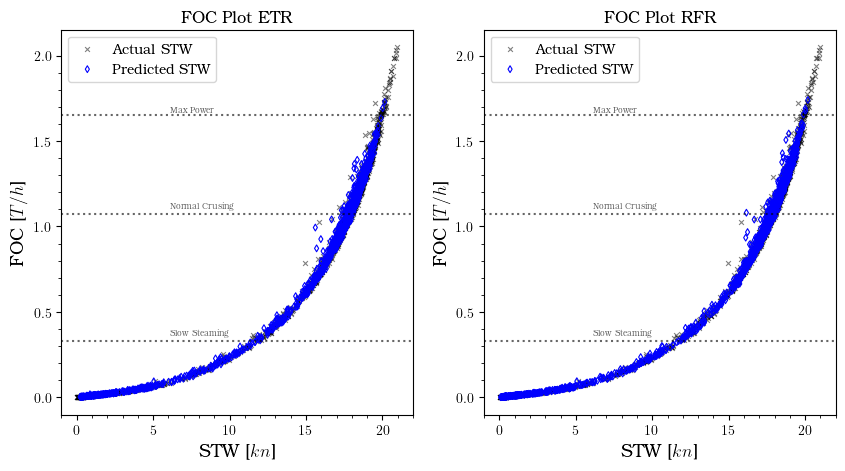

In [249]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
FOC_coeff_plot('ETR',stw_pred_et_yr,stw_act_yr,FOC_pred_yr,FOC_act_yr)
plt.sca(axes[1])
FOC_coeff_plot('RFR',stw_pred_rf_yr,stw_act_yr,FOC_pred_rf_yr,FOC_act_yr)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.2)
plt.show()

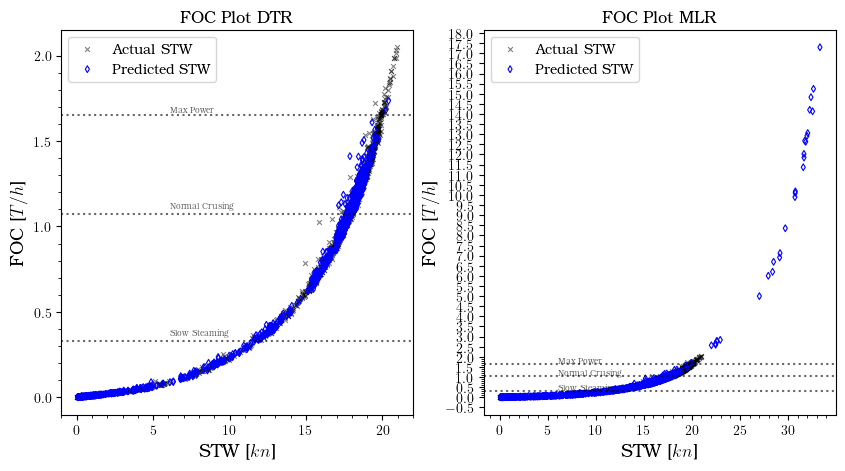

In [250]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
FOC_coeff_plot('DTR',stw_pred_dt_yr,stw_act_yr,FOC_pred_dt_yr,FOC_act_yr)
plt.sca(axes[1])
FOC_coeff_plot('MLR',stw_pred_mlr_yr,stw_act_yr,FOC_pred_mlr_yr,FOC_act_yr)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.2)
plt.show()

Actual data polyfit

In [213]:
# plt.figure(figsize=(12, 18))
# gs = gridspec.GridSpec(2, 4)
# gs.update(wspace=0.5)
# ax1 = plt.subplot(gs[0, :2] )
# poly_act_yr = poly_reg_best_fit('DS_{YEAR}',stw_act_yr,FOC_act_yr)
# ax2 = plt.subplot(gs[0, 2:])
# poly_act_s = poly_reg_best_fit('DS_{WINTER}',stw_act_w,FOC_act_w)
# ax3 = plt.subplot(gs[1, 1:3])
# poly_act_w = poly_reg_best_fit('DS_{SUMMER}',stw_act_s,FOC_act_s)
# plt.show()

ETR polyfit plot

ValueError: Input X contains NaN.
PolynomialFeatures does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

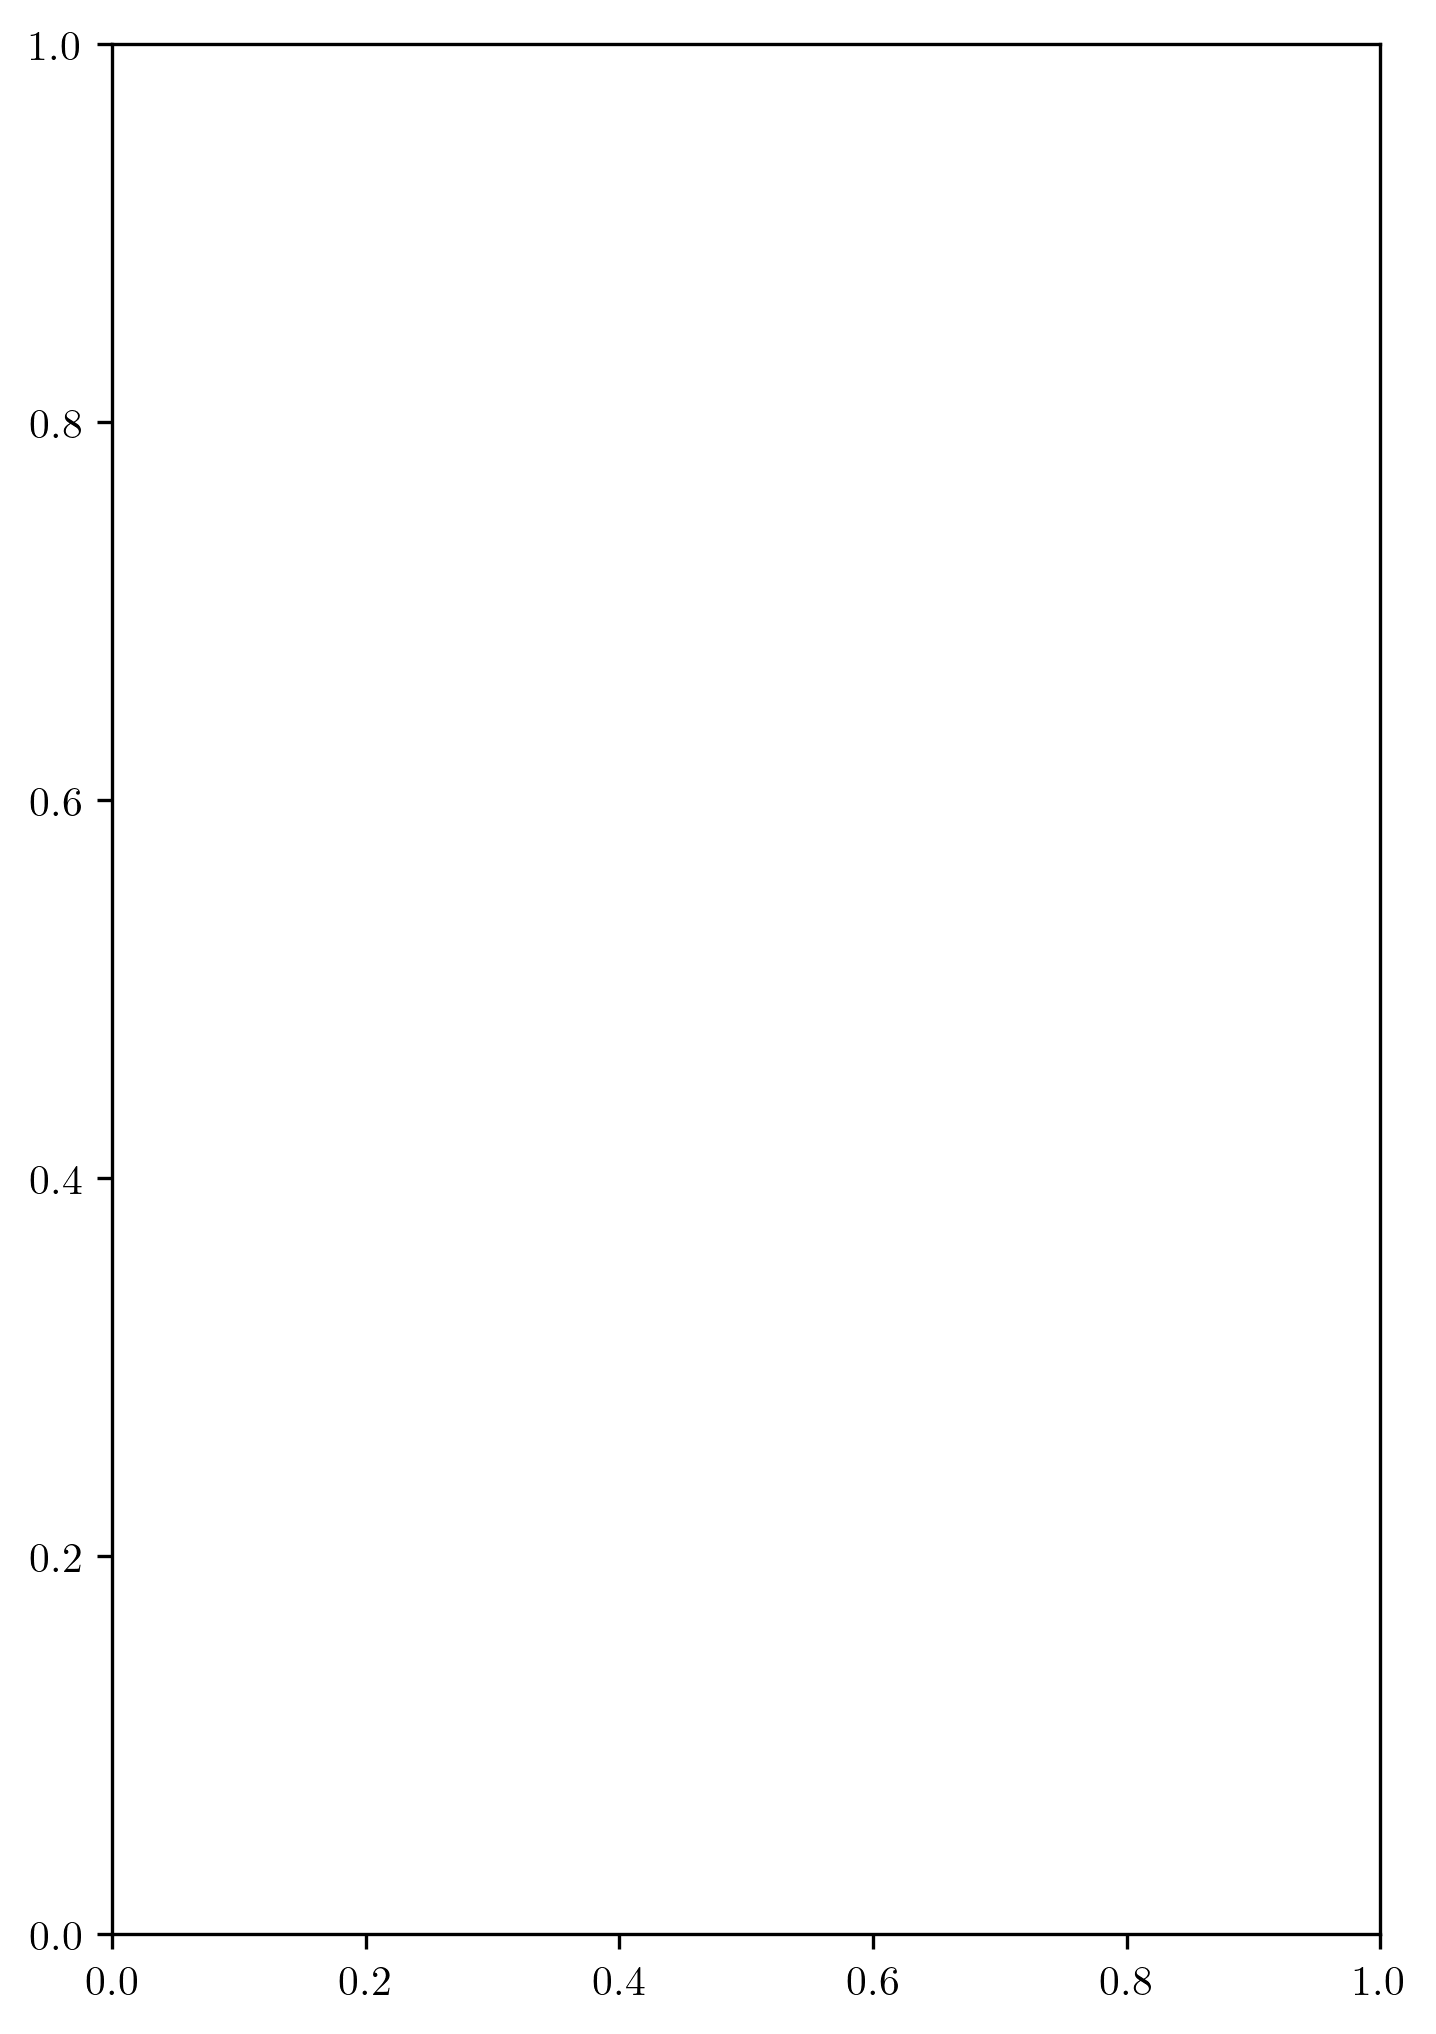

In [223]:
# plt.figure(figsize=(12, 18))
# gs = gridspec.GridSpec(2, 4)
# gs.update(wspace=0.5)
# ax1 = plt.subplot(gs[0, :2] )
# poly_etr_yr = poly_reg_best_fit('DS_{YEAR}',stw_pred_et_yr,FOC_pred_yr)
# ax2 = plt.subplot(gs[0, 2:])
# poly_etr_w = poly_reg_best_fit('DS_{WINTER}',stw_pred_et_w,FOC_pred_w)
# ax3 = plt.subplot(gs[1, 1:3])
# poly_etr_s = poly_reg_best_fit('DS_{SUMMER}',stw_pred_et_s,FOC_pred_s)
# plt.show()

RFR polyfit FOC

In [229]:
# poly_rfr_yr = poly_reg_best_fit('DS_{YEAR}',stw_pred_rf_yr,FOC_pred_rf_yr)
# plt.show()

In [230]:
# plt.figure(figsize=(12, 18))
# gs = gridspec.GridSpec(2, 4)
# gs.update(wspace=0.5)
# ax1 = plt.subplot(gs[0, :2] )
# poly_rfr_yr = poly_reg_best_fit('DS_{YEAR}',stw_pred_rf_yr,FOC_pred_rf_yr)
# ax2 = plt.subplot(gs[0, 2:])
# poly_rfr_w = poly_reg_best_fit('DS_{WINTER}',stw_pred_rf_w,FOC_pred_rf_w)
# ax3 = plt.subplot(gs[1, 1:3])
# poly_rfr_s = poly_reg_best_fit('DS_{SUMMER}',stw_pred_rf_s,FOC_pred_rf_s)
# plt.show()

DTR

Best Polynomial Equation:
$y = 0.0092 + (-0.0097)x^1 + (0.0067)x^2 + (-0.0006)x^3 + (0.0000)x^4$
Best Polynomial Equation:
$y = 0.0082 + (-0.0075)x^1 + (0.0061)x^2 + (-0.0005)x^3 + (0.0000)x^4$
Best Polynomial Equation:
$y = 0.0096 + (-0.0107)x^1 + (0.0069)x^2 + (-0.0006)x^3 + (0.0000)x^4$


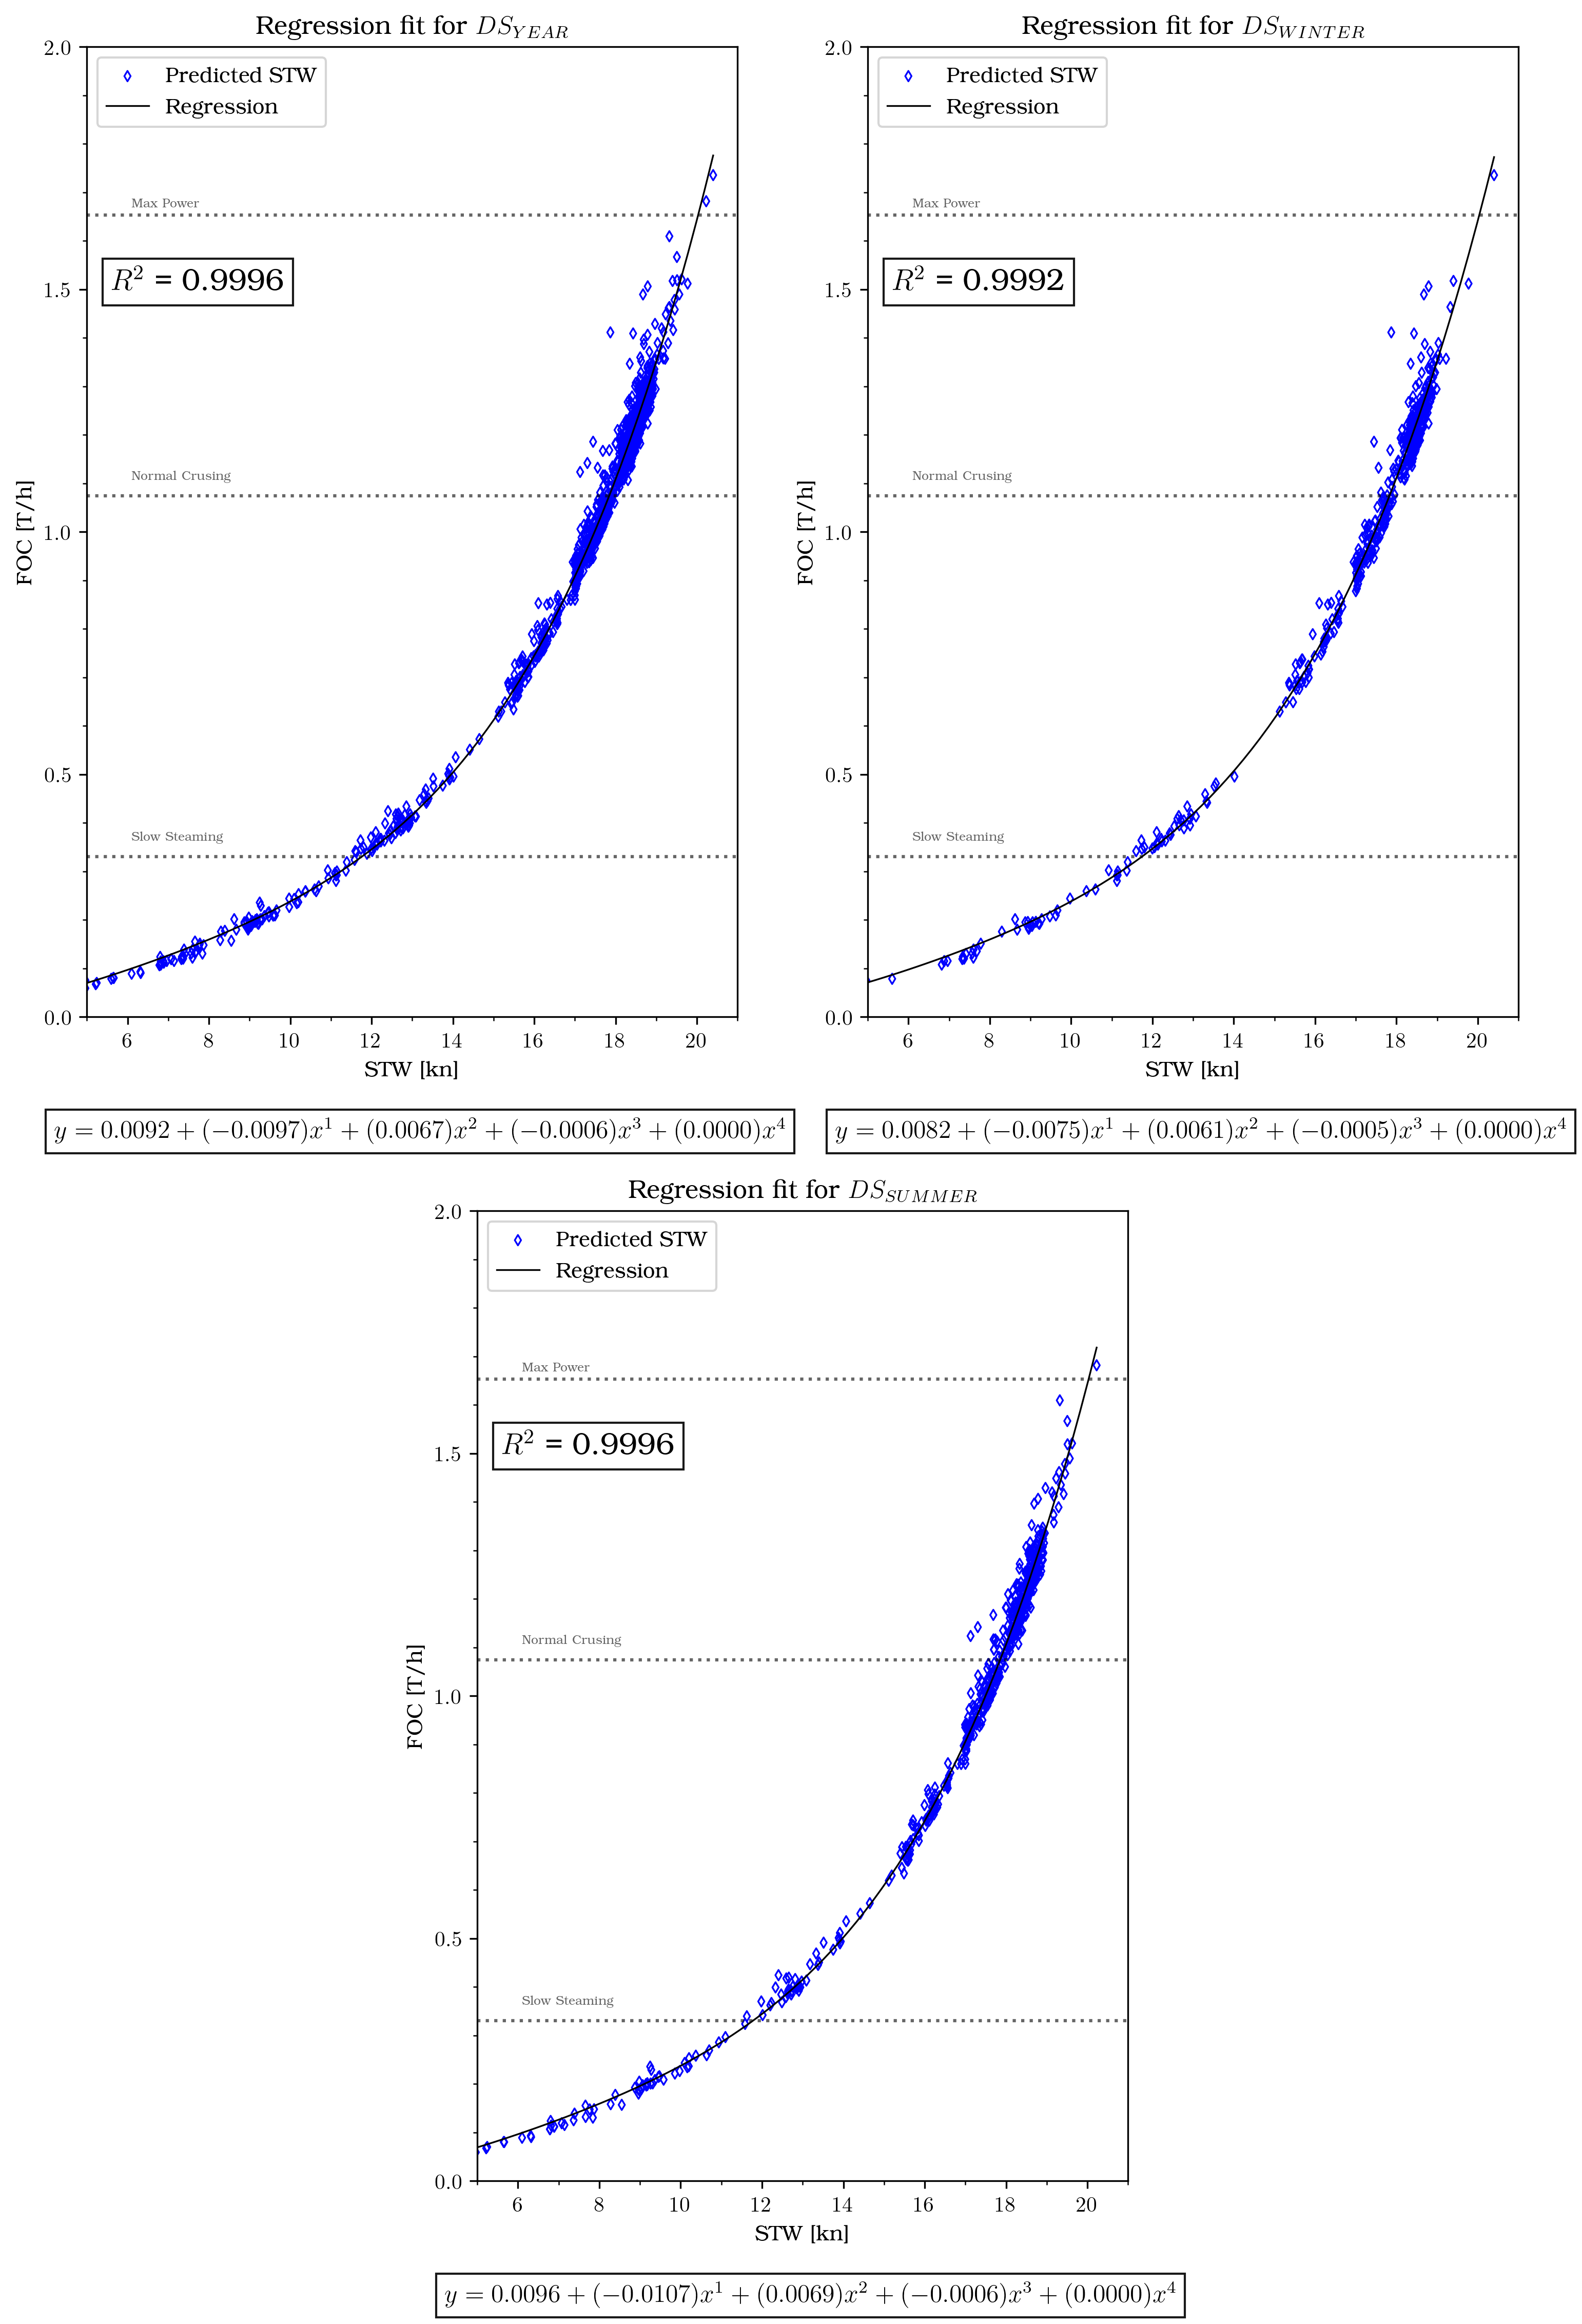

In [235]:
plt.figure(figsize=(12, 18))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2] )
poly_dtr_yr = poly_reg_best_fit('DS_{YEAR}',stw_pred_dt_yr.dropna(),FOC_pred_dt_yr.dropna())
ax2 = plt.subplot(gs[0, 2:])
poly_dtr_w = poly_reg_best_fit('DS_{WINTER}',stw_pred_dt_w.dropna(),FOC_pred_dt_w.dropna())
ax3 = plt.subplot(gs[1, 1:3])
poly_dtr_s = poly_reg_best_fit('DS_{SUMMER}',stw_pred_dt_s.dropna(),FOC_pred_dt_s.dropna())
plt.show()

Evaluating model performance on FOC prediction

In [232]:
# This function defines the model performance for the given stw range

def evaluate_FOC(model,FOC_act,FOC_pred):
    from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_error
    
    Rsquared_FOC = r2_score(FOC_act,FOC_pred)
    expVar_FOC = explained_variance_score(FOC_act,FOC_pred)
    MAE_FOC = mean_absolute_error(FOC_act,FOC_pred)
    RMSE_FOC = np.sqrt(mean_squared_error(FOC_act, FOC_pred))
    MAD_FOC = median_absolute_error(FOC_act,FOC_pred)
    MAPE_FOC = mean_absolute_percentage_error(FOC_act, FOC_pred)
    
    print(f"Model Performance of {model}")
    print(f"R^2 {Rsquared_FOC:0.4f}")
    print(f"Explained Variance {expVar_FOC:0.4f}")
    print(f"MAE {MAE_FOC:0.4f} T/h")    
    print(f"RMSE FOC {RMSE_FOC:0.4f} T/h")
    print(f"MAD {MAD_FOC:0.4f} T/h")    
    print(f"MAPE FOC {MAPE_FOC*100:0.4f} %")


ETR

In [234]:
# Yearly performance 


evaluate_FOC(model_etr_hpov,FOC_act_yr.dropna(),FOC_pred_yr.dropna())

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 0.8717
Explained Variance 0.8791
MAE 0.1228 T/h
RMSE FOC 0.1878 T/h
MAD 0.0750 T/h
MAPE FOC 61.9443 %


In [236]:
evaluate_FOC(model_etr_hpov,FOC_act_s.dropna(),FOC_pred_s.dropna())

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 0.8826
Explained Variance 0.8899
MAE 0.1218 T/h
RMSE FOC 0.1828 T/h
MAD 0.0790 T/h
MAPE FOC 54.5504 %


In [237]:
evaluate_FOC(model_etr_hpov,FOC_act_w.dropna(),FOC_pred_w.dropna())

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 0.8555
Explained Variance 0.8630
MAE 0.1242 T/h
RMSE FOC 0.1945 T/h
MAD 0.0713 T/h
MAPE FOC 71.5133 %


RFR

In [238]:
# On yearly data

evaluate_FOC(model_rfr_hpov,FOC_act_yr.dropna(),FOC_pred_rf_yr.dropna())

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 0.8812
Explained Variance 0.8848
MAE 0.1141 T/h
RMSE FOC 0.1807 T/h
MAD 0.0690 T/h
MAPE FOC 49.3529 %


In [239]:
evaluate_FOC(model_rfr_hpov,FOC_act_s.dropna(),FOC_pred_rf_s.dropna())

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 0.8904
Explained Variance 0.8936
MAE 0.1133 T/h
RMSE FOC 0.1766 T/h
MAD 0.0729 T/h
MAPE FOC 45.6114 %


In [240]:
evaluate_FOC(model_rfr_hpov,FOC_act_w.dropna(),FOC_pred_rf_w.dropna())

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 0.8686
Explained Variance 0.8728
MAE 0.1152 T/h
RMSE FOC 0.1855 T/h
MAD 0.0647 T/h
MAPE FOC 54.3139 %


DTR

In [241]:
evaluate_FOC(model_dtr_hpov,FOC_act_yr.dropna(),FOC_pred_dt_yr.dropna())

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 0.8106
Explained Variance 0.8125
MAE 0.1450 T/h
RMSE FOC 0.2281 T/h
MAD 0.0841 T/h
MAPE FOC 41.5836 %


In [242]:
evaluate_FOC(model_dtr_hpov,FOC_act_s.dropna(),FOC_pred_dt_s.dropna())

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 0.7965
Explained Variance 0.7985
MAE 0.1550 T/h
RMSE FOC 0.2407 T/h
MAD 0.0860 T/h
MAPE FOC 41.6584 %


In [243]:
evaluate_FOC(model_dtr_hpov,FOC_act_w.dropna(),FOC_pred_dt_w.dropna())

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 0.8320
Explained Variance 0.8337
MAE 0.1319 T/h
RMSE FOC 0.2098 T/h
MAD 0.0824 T/h
MAPE FOC 40.7657 %


MLR

In [244]:
#yearly data

evaluate_FOC(model_mlr_ftr,FOC_act_yr.dropna(),FOC_pred_mlr_yr.dropna())

Model Performance of LinearRegression()
R^2 -7.4433
Explained Variance -7.4425
MAE 0.4565 T/h
RMSE FOC 1.5233 T/h
MAD 0.2101 T/h
MAPE FOC 11458.9238 %


In [245]:
evaluate_FOC(model_mlr_ftr,FOC_act_s.dropna(),FOC_pred_mlr_s.dropna())

Model Performance of LinearRegression()
R^2 -5.9591
Explained Variance -5.9591
MAE 0.4393 T/h
RMSE FOC 1.4073 T/h
MAD 0.2044 T/h
MAPE FOC 10828.4296 %


In [246]:
evaluate_FOC(model_mlr_ftr,FOC_act_w.dropna(),FOC_pred_mlr_w.dropna())

Model Performance of LinearRegression()
R^2 -9.5748
Explained Variance -9.5683
MAE 0.4784 T/h
RMSE FOC 1.6641 T/h
MAD 0.2228 T/h
MAPE FOC 12291.8402 %


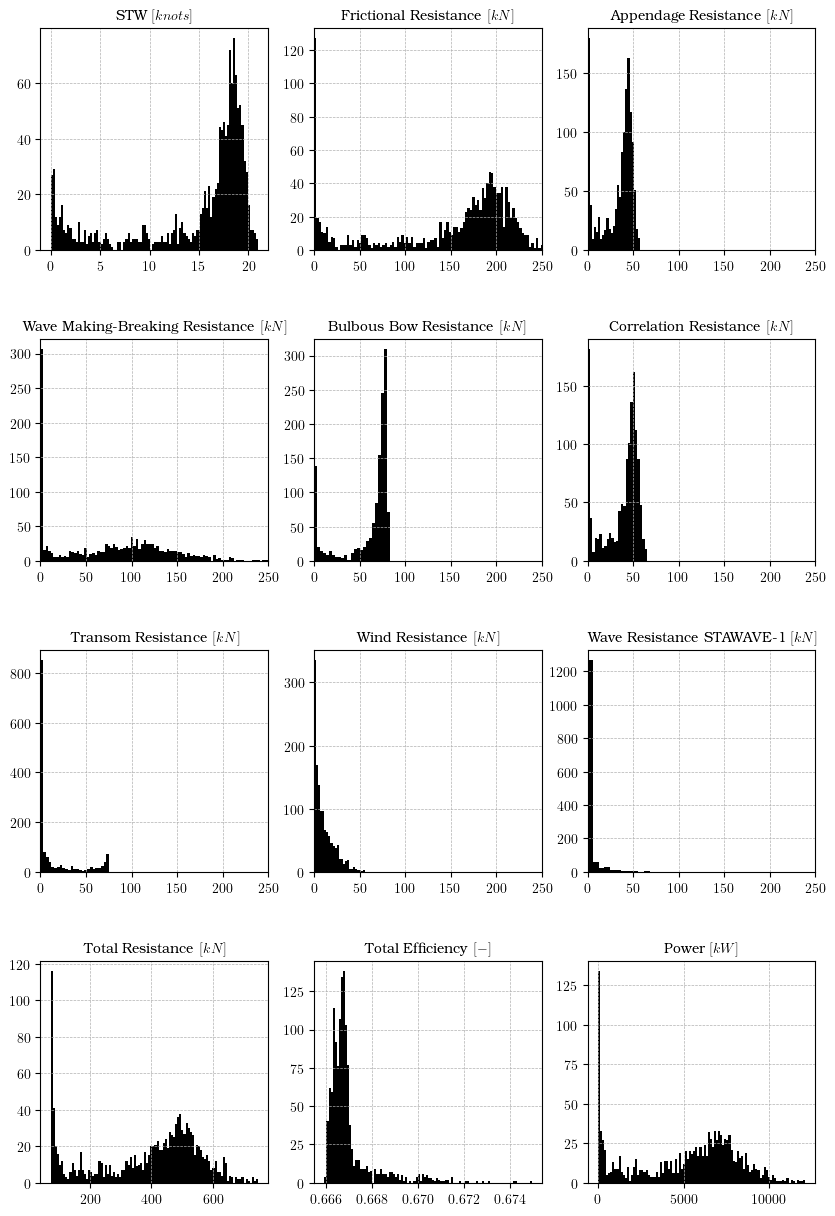

In [247]:
fs = 10

plt.rcParams.update(plt.rcParamsDefault)
# Parameter to plot in nice latex fonts
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})


stw = stw_act_yr
R_f = Rf_act_yr/1e3
R_app = R_app_act_yr/1e3
R_w = R_w_act_yr/1e3
R_b = R_b_act_yr/1e3
R_tr = R_tr_act_yr/1e3
R_a = R_a_act_yr/1e3
R_aa = R_aa_act_yr/1e3
# R_aa_hm = dfprog_f['R_aa_hm']/1e3
R_awl = R_awl_act_yr/1e3
R_tot = R_tot_act_yr
# eff_h = dfprog_f['eff_h']
eff_tot = eff_tot_act_yr
P_b = P_b_act_yr
FOC = FOC_act_yr



fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 15))

axes[0, 0].hist(stw,bins=100,color='black')
axes[0, 0].set_title(r'STW $[knots]$', fontsize=fs)
axes[0, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[0, 1].hist(R_f,bins=100,color='black')
axes[0, 1].set_title(r'Frictional Resistance $[kN]$', fontsize=fs)
axes[0, 1].grid(True,linestyle = '--', linewidth = 0.5)
axes[0, 1].set_xlim(0,250)

axes[0, 2].hist(R_app,bins=25,color='black')
axes[0, 2].set_title(r'Appendage Resistance $[kN]$', fontsize=fs)
axes[0, 2].grid(True,linestyle = '--', linewidth = 0.5)
axes[0, 2].set_xlim(0,250)

axes[1, 0].hist(R_w,bins=100,color='black')
axes[1, 0].set_title(r'Wave Making-Breaking Resistance $[kN]$', fontsize=fs)
axes[1, 0].grid(True,linestyle = '--', linewidth = 0.5)
axes[1, 0].set_xlim(0,250)

axes[1, 1].hist(R_b  ,bins=25,color='black')
axes[1, 1].set_title(r'Bulbous Bow Resistance $[kN]$', fontsize=fs)
axes[1, 1].grid(True,linestyle = '--', linewidth = 0.5)
axes[1, 1].set_xlim(0,250)

axes[1, 2].hist(R_a,bins=25,color='black')
axes[1, 2].set_title(r'Correlation Resistance $[kN]$', fontsize=fs)
axes[1, 2].grid(True,linestyle = '--', linewidth = 0.5)
axes[1, 2].set_xlim(0,250)

axes[2, 1].hist(R_aa,bins=25,color='black')
axes[2, 1].set_title(r'Wind Resistance $[kN]$', fontsize=fs)
axes[2, 1].grid(True,linestyle = '--', linewidth = 0.5)
axes[2, 1].set_xlim(0,250)

# axes[2, 0].hist(R_aa_hm,bins=25,color='black')
# axes[2, 0].set_title(r'Wind Resistance $[kN]$', fontsize=fs)
# axes[2, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[2, 2].hist(R_awl,bins=25,color='black')
axes[2, 2].set_title(r'Wave Resistance STAWAVE-1 $[kN]$', fontsize=fs)
axes[2, 2].grid(True,linestyle = '--', linewidth = 0.5)
axes[2, 2].set_xlim(0,250)

axes[2, 0].hist(R_tr,bins=25,color='black')
axes[2, 0].set_title(r'Transom Resistance $[kN]$', fontsize=fs)
axes[2, 0].grid(True,linestyle = '--', linewidth = 0.5)
axes[2, 0].set_xlim(0,250)

axes[3, 0].hist(R_tot,bins=100,color='black')
axes[3, 0].set_title(r'Total Resistance $[kN]$', fontsize=fs)
axes[3, 0].grid(True,linestyle = '--', linewidth = 0.5)

# axes[3, 0].hist(eff_h,bins=25,color='black')
# axes[3, 0].set_title(r'Hull Efficiency $[-]$', fontsize=fs)
# axes[3, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 1].hist(eff_tot,bins=100,color='black')
axes[3, 1].set_title(r'Total Efficiency $[-]$', fontsize=fs)
axes[3, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 2].hist(P_b,bins=100,color='black')
axes[3, 2].set_title(r'Power $[kW]$', fontsize=fs)
axes[3, 2].grid(True,linestyle = '--', linewidth = 0.5)

# axes[4, 1].hist(FOC,bins=25,color='black')
# axes[4, 1].set_title(r'Fuel Consumption $[t/h]$', fontsize=fs)
# axes[4, 1].grid(True,linestyle = '--', linewidth = 0.5)

fig.subplots_adjust(hspace=0.4)
plt.show()

In [ ]:
def FOC_plot_yr(FOC_actual_yr,FOC_ETR_yr,FOC_RFR_yr,FOC_DTR_yr):
    rmse_opt = [FOC_actual_yr,FOC_ETR_yr,FOC_RFR_yr,FOC_DTR_yr]
    # fig = plt.figure(figsize=(5,3))
    # Creating axes instance
    fig,ax = plt.subplots() 
    plt.title("FOC comparison for yearly data")
    plt.ylabel("FOC [T/h]")
    plt.xlabel("Period")
    plt.yscale('linear')
    ax.boxplot(rmse_opt,showmeans=True)
    plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
    ax.set_xticklabels([r'$FOC_{actual}$', r'$FOC_{ETR}$',
                        r'$FOC_{RFR}$', r'$FOC_{DTR}$'])

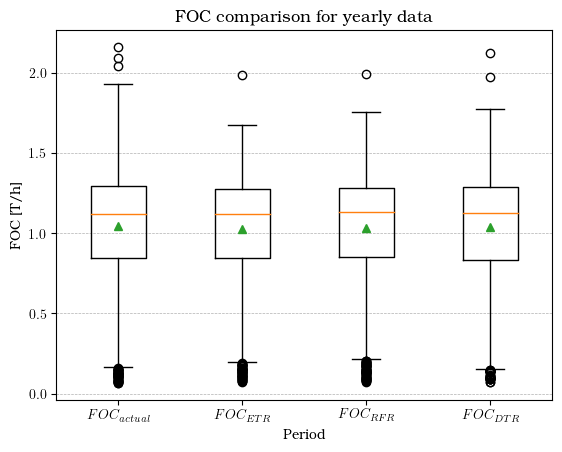

In [ ]:
FOC_plot_yr(FOC_act_yr,FOC_pred_yr,FOC_pred_rf_yr,FOC_pred_dt_yr)
plt.show()